In [1]:
# 패키지 불러오기
import pandas as pd  # pandas
import numpy as np   # numpy
import matplotlib.pyplot as plt  # matplotlib.pyplot
%matplotlib inline
# 한글 설정
from matplotlib import font_manager, rc   
plt.rcParams['axes.unicode_minus'] = False   # 그래프 한글 설정을 위해 matplotlib에서 rc 불러오기 (한글 깨짐 현상을 막아줌)

import platform  # platform 
if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

import seaborn as sns 
import datetime  
from scipy import stats  
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import warnings   # warning ignore
warnings.filterwarnings('ignore')

## 1. 데이터 전처리 

### 1-1. 연령대 정보 (파일명 : age_gender_bkts)
- 첫 번째 단계는 판다스 데이터 프레임을 사용하여, 가능한 모든 데이터를 로드하고 샘플수, null값, 피쳐값 등과 같은 기본 정보를 추출. 
- 다음 단계는 적절한 방법(드랍, 추가 등)을 사용하여 누락된 값을 처리하여 통계 및 머신러닝 알고리즘을 적용하기에 더 적합한 형태로 만들기.

In [2]:
# 연령대 데이터 정보 불러오기
df_agb = pd.read_csv('datas2/age_gender_bkts.csv')
df_agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


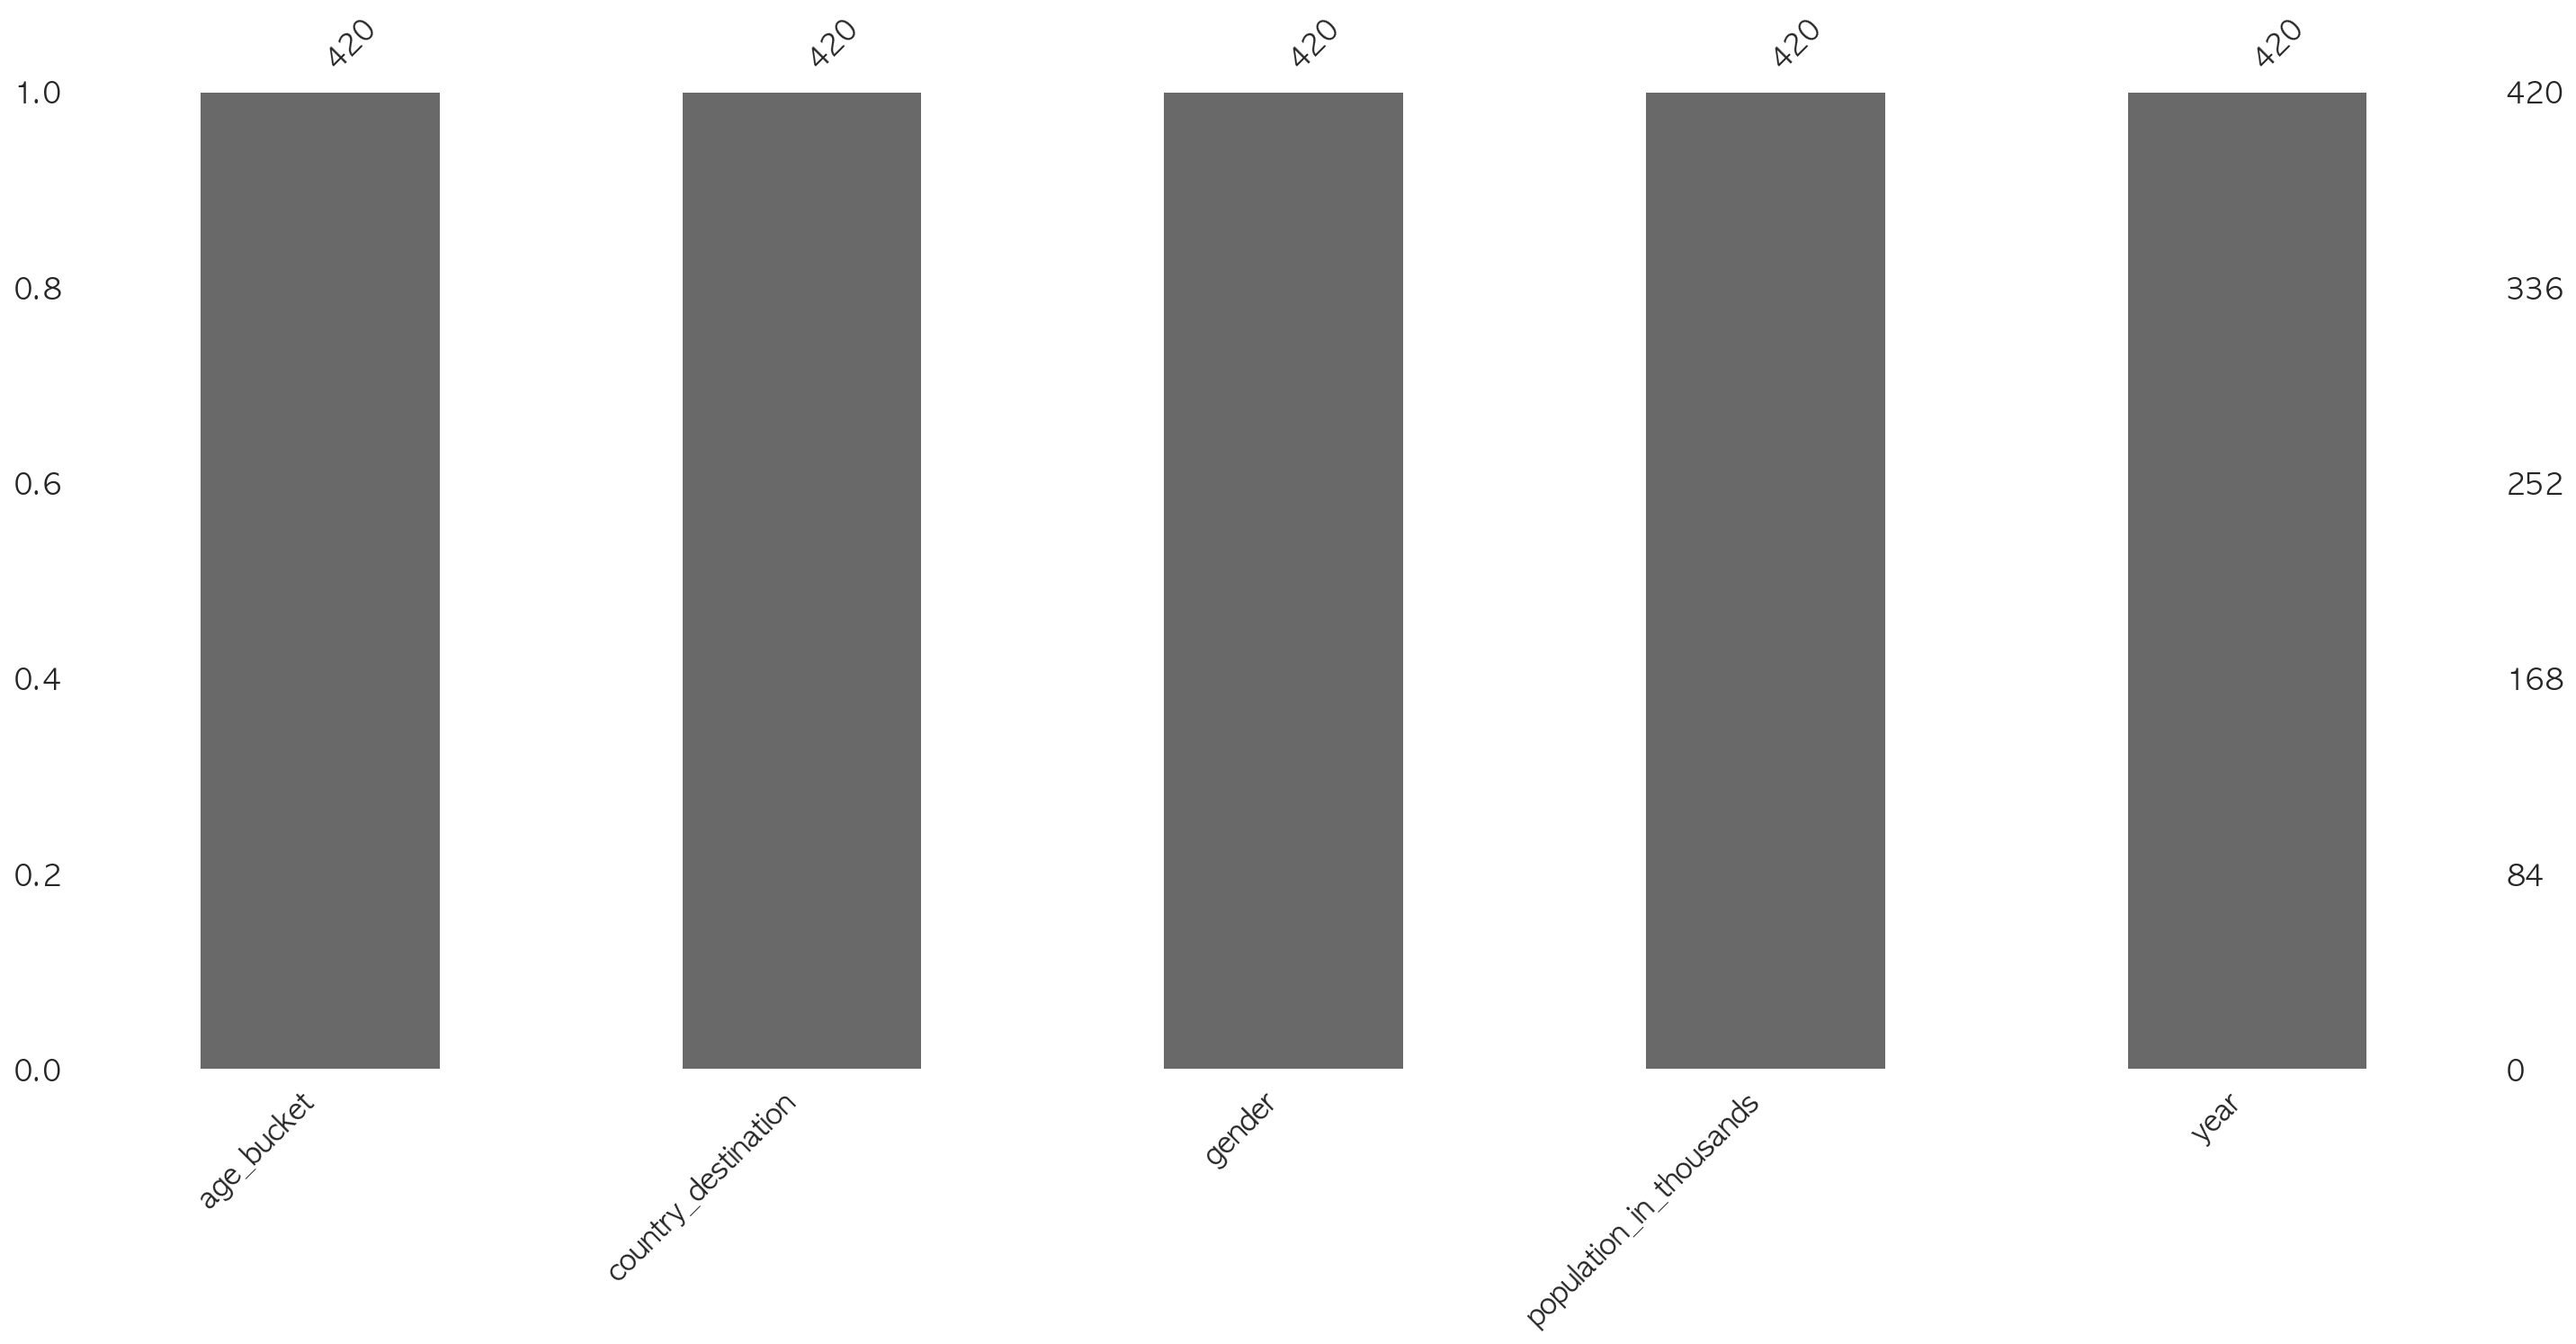

In [3]:
import missingno as msno
msno.bar(df_agb)
plt.show()

- 컬럼 소개
    - age_bucket : 연령대 (예: 10-14)
    - country_destination : 목적지 국가
    - gender : 성별
    - population_in_thousands : (인구수 - 단위:1000명)

In [4]:
df_agb.isnull().values.any()

False

- 해당 데이터('age_gender_bkts')에는 null 값이 존재하지 않음.
- 첫번째 단계로 연령 데이터, 연령의 크기는 5개의 컬럼으로 형성 됨. 필요할 경우 다용도를 높일 수 있도록 숫자 값으로 변환. 해당 데이터의 크기가 작기 때문에 정보 손실없이 연령을 나타낼 수 있는 mean_age를 정의 할 수 있음.

In [5]:
df_agb['age_bucket'].value_counts(ascending=True)

45-49    20
90-94    20
55-59    20
35-39    20
15-19    20
95-99    20
75-79    20
70-74    20
50-54    20
80-84    20
0-4      20
40-44    20
30-34    20
100+     20
25-29    20
65-69    20
10-14    20
20-24    20
60-64    20
5-9      20
85-89    20
Name: age_bucket, dtype: int64

In [6]:
# mean_age컬럼을 추가하여 100+에서 100-104의 데이터로 변환
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)

# mean_age feature 정의 (예: 100-104를 -기준으로 나누고 정수형으로 바꾼 뒤, 두 수를 더해서 2로 나눔)
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [7]:
# 목적지 국가 정보 조회
df_agb['country_destination'].value_counts()

ES    42
GB    42
IT    42
AU    42
DE    42
US    42
NL    42
FR    42
CA    42
PT    42
Name: country_destination, dtype: int64

- 국가 수가 극히 적음. 이 섹션의 뒷부분에서 다룰 train 데이터 세트에서 사용할 수 있는 국가에 해당. 

In [8]:
# 성별 분포 조회 
df_agb['gender'].value_counts()

female    210
male      210
Name: gender, dtype: int64

- 성별이 둘 만 있기 때문에 우선 0과 1을 이진분류를 진행 

In [9]:
# 성별 0, 1로 이진분류 - 0: 남자, 1: 여자
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_agb['gender'].value_counts()

0    210
1    210
Name: gender, dtype: int64

In [10]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

- 연도의 갯수가 하나밖에 없으므로 의미없다고 판단 연도 컬럼을 drop

In [11]:
df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


### 1-2. 목적지 국가 데이터 (파일명: countries)

In [12]:
df_con = pd.read_csv('datas2/countries.csv')
df_con

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


- 컬럼소개
    - country_destination : 목적지 국가
    - lat_destination : 위도
    - lng_destination : 경도
    - distance_km : 거리 (단위: km)
    - destination_km2 : 해당국가 면적 (km2)
    - destination_language : 해당국가 언어
    - language_levenshtein_distance : 해당국가의 언어 유사도 (0.0:유사함)

- 해당 데이터셋은 데이터 자체가 작기 때문에 어떠한 작업도 필요없을 것이라 판단됨. 여기에 제시된 통계는 모델을 train하기 전, test 데이터셋에 통합되거나 추가 insight를 도출하기 위해 EDA에 사용되어야 할 것이라 생각됨.

### 1-3. 사용자 접속 데이터 (파일명: sessions) 

In [13]:
# session 데이터 불러오기 
df_ses = pd.read_csv('datas2/sessions.csv')
df_ses.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


- 컬럼소개 
    - user_id : 유저 아이디
    - action : 유저 활동 내역
    - action_type : 유저 활동 타입
    - action_detail : 유저 활동 디테일
    - device_type : 디바이스 타입 
    - secs_elapsed : 웹에 머무르는 시간 (단위: 초)

In [14]:
# 데이터 크기 살펴보기
df_ses.shape

(10567737, 6)

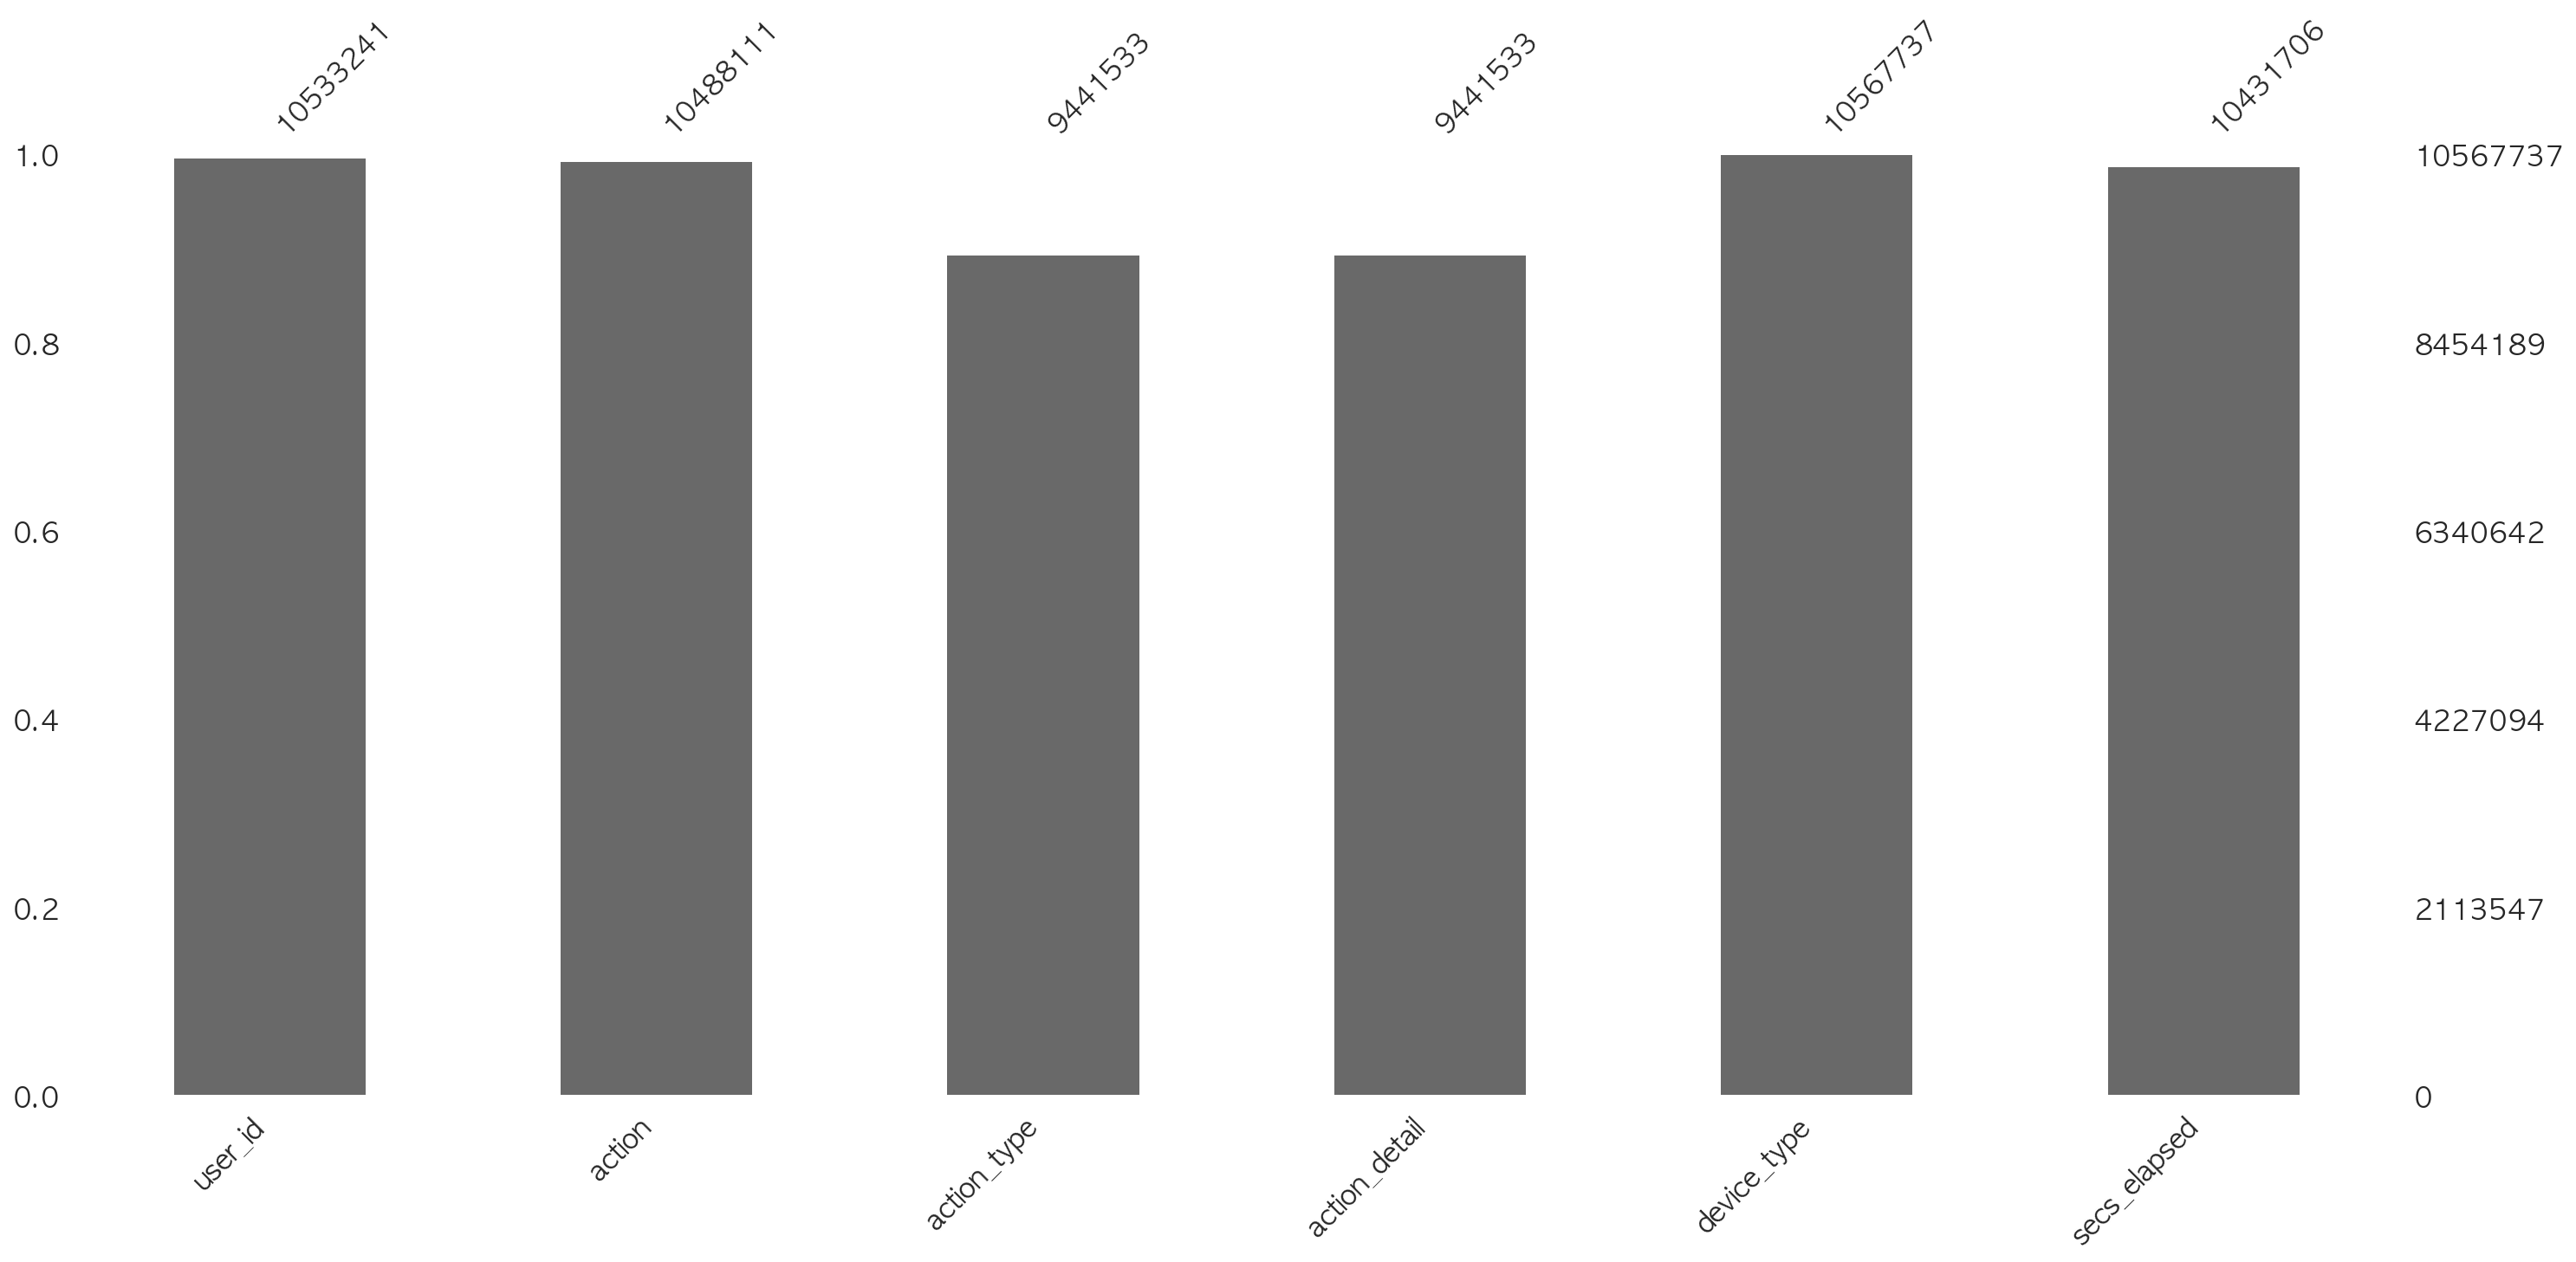

In [15]:
import missingno as msno
msno.bar(df_ses)
plt.show()

In [16]:
# 각 컬럼마다 결측치가 얼마나 있는지 찾기
for i in df_ses.columns:
    ab = df_ses[i].isnull().sum()
    if ab != 0:
        print(i + "has {} null values.".format(ab))
        print()

user_idhas 34496 null values.

actionhas 79626 null values.

action_typehas 1126204 null values.

action_detailhas 1126204 null values.

secs_elapsedhas 136031 null values.



In [17]:
# session에 유저들 활동 사항 확인 
df_ses['action'].unique()

array(['lookup', 'search_results', 'personalize', 'index',
       'similar_listings', 'ajax_refresh_subtotal', 'show',
       'header_userpic', 'ask_question', nan,
       'other_hosting_reviews_first', 'hosting_social_proof',
       'decision_tree', 'recent_reservations', 'faq_experiment_ids',
       'multi', 'active', 'dashboard', 'create', 'confirm_email',
       'show_personalize', 'verify', 'pending', 'requested', 'concierge',
       'faq', 'clear_reservation', 'cancellation_policies',
       'track_page_view', 'update', 'my', 'campaigns', 'notifications',
       'listings', 'unavailabilities', 'ajax_lwlb_contact',
       'ajax_check_dates', 'qt2', 'request_new_confirm_email',
       'ajax_photo_widget_form_iframe', 'facebook_auto_login', 'identity',
       'qt_reply_v2', 'travel_plans_current', 'complete_status',
       'populate_from_facebook', 'kba_update', 'kba', 'login',
       'authenticate', 'calendar_tab_inner2', 'other_hosting_reviews',
       'social_connections', 'relat

In [18]:
# session 데이터 내에서 unknown으로 되어 있는 데이터 결측치로 만들기 
df_ses['action'] = df_ses['action'].replace('-unknown-', np.nan)
df_ses['action_type'] = df_ses['action_type'].replace('-unknown-', np.nan)
df_ses['action_detail'] = df_ses['action_detail'].replace('-unknown-', np.nan)

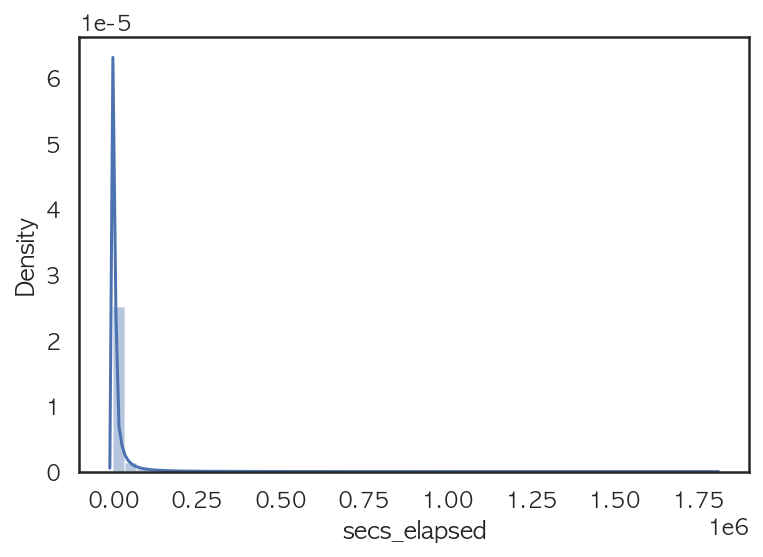

In [19]:
# secs_elapsed(웹에 머무르는 시간(초))의 결측치 없는 데이터 확인 
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed']);

- 최대 밀도 0.00006

In [20]:
df_ses['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

- 웹에 머무르는 시간 평균 19405초, 중앙값 1147초

In [21]:
# null 값 확인 - 136,031
len(df_ses[df_ses['secs_elapsed'].isnull()])

136031

In [22]:
# 결측치 채우기 - 중앙값으로 
median_secs = df_ses['secs_elapsed'].median()
df_ses['secs_elapsed'] = df_ses['secs_elapsed'].fillna(median_secs)

In [23]:
df_ses['secs_elapsed'].describe()

count    1.056774e+07
mean     1.917078e+04
std      8.833430e+04
min      0.000000e+00
25%      2.370000e+02
50%      1.147000e+03
75%      8.193000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

- null값을 중앙값으로 채워도 엄청 크게 변경되지 않는듯 함. 아무래도 다른 데이터들도 중앙값으로 채워도 괜찮지 않을까? 라는 생각을 하게 됨.

In [24]:
# 유저들의 활동내역 - action_type, action_detail, action 등의 null 값만 출력 
null_action = df_ses[(df_ses['action_type'].isnull()) | (df_ses['action_detail'].isnull()) | 
                    (df_ses['action'].isnull())]
null_action.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [25]:
# 확인해보니 결측치만 2,237,000개
null_action.shape

(2237000, 6)

In [26]:
# 중복되는 결측치 drop을 몇개 했는지 확인 
len(null_action['action'].drop_duplicates())

270

In [27]:
# dvice_type은 null 값이 없음.
df_ses[df_ses['device_type'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [28]:
# Device type을 확인해보니 -unknown-의 값이 있음.
df_ses['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [29]:
# -unknown-의 값을 null값으로 변환 
df_ses['device_type'] = df_ses['device_type'].replace('-unknown-', np.nan)

In [30]:
df_ses['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [31]:
# null 값 확인 - 211,279개
len(df_ses[df_ses['device_type'].isnull()])

211279

- 유저활동과 마찬가지로 값은 머신러닝 알고리즘을 적용 할 데이터셋이 아니므로 삭제하지 않음.

### 1-4. Train 데이터셋

In [32]:
df_train = pd.read_csv('datas2/train_users_2.csv')
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


- 컬럼소개 
    - id : 유저 ID
    - date_account_created : 계정 생성 날짜
    - timestamp_first_active : 유저 첫 활동 시간
    - date_first_booking : 첫 예약일 
    - gender : 연령대
    - age : 성별
    - signup_method : 가입 방법 (경로)
    - signup_flow : 가입 흐름 - 사용자가 가입하기 위한 페이지에 들어간 횟수
    - language : 해당 국가의 언어
    - affiliate_channel : 제휴 채널
    - affiliate_provider : 제휴 제공자
    - first_affiliate_tracked : 첫번째 제휴사 추적 : 가입하기 전에 사용자가 처음으로 상호 작용 한 마케팅 내용
    - signup_app : 로그인 어플리케이션
    - first_device_type : 첫번째 디바이스 타입
    - first_browser : 첫번째 브라우져 타입
    - country_destination : 목적지 국가 (target data)

In [33]:
# 데이터 확인 
df_train.shape

(213451, 16)

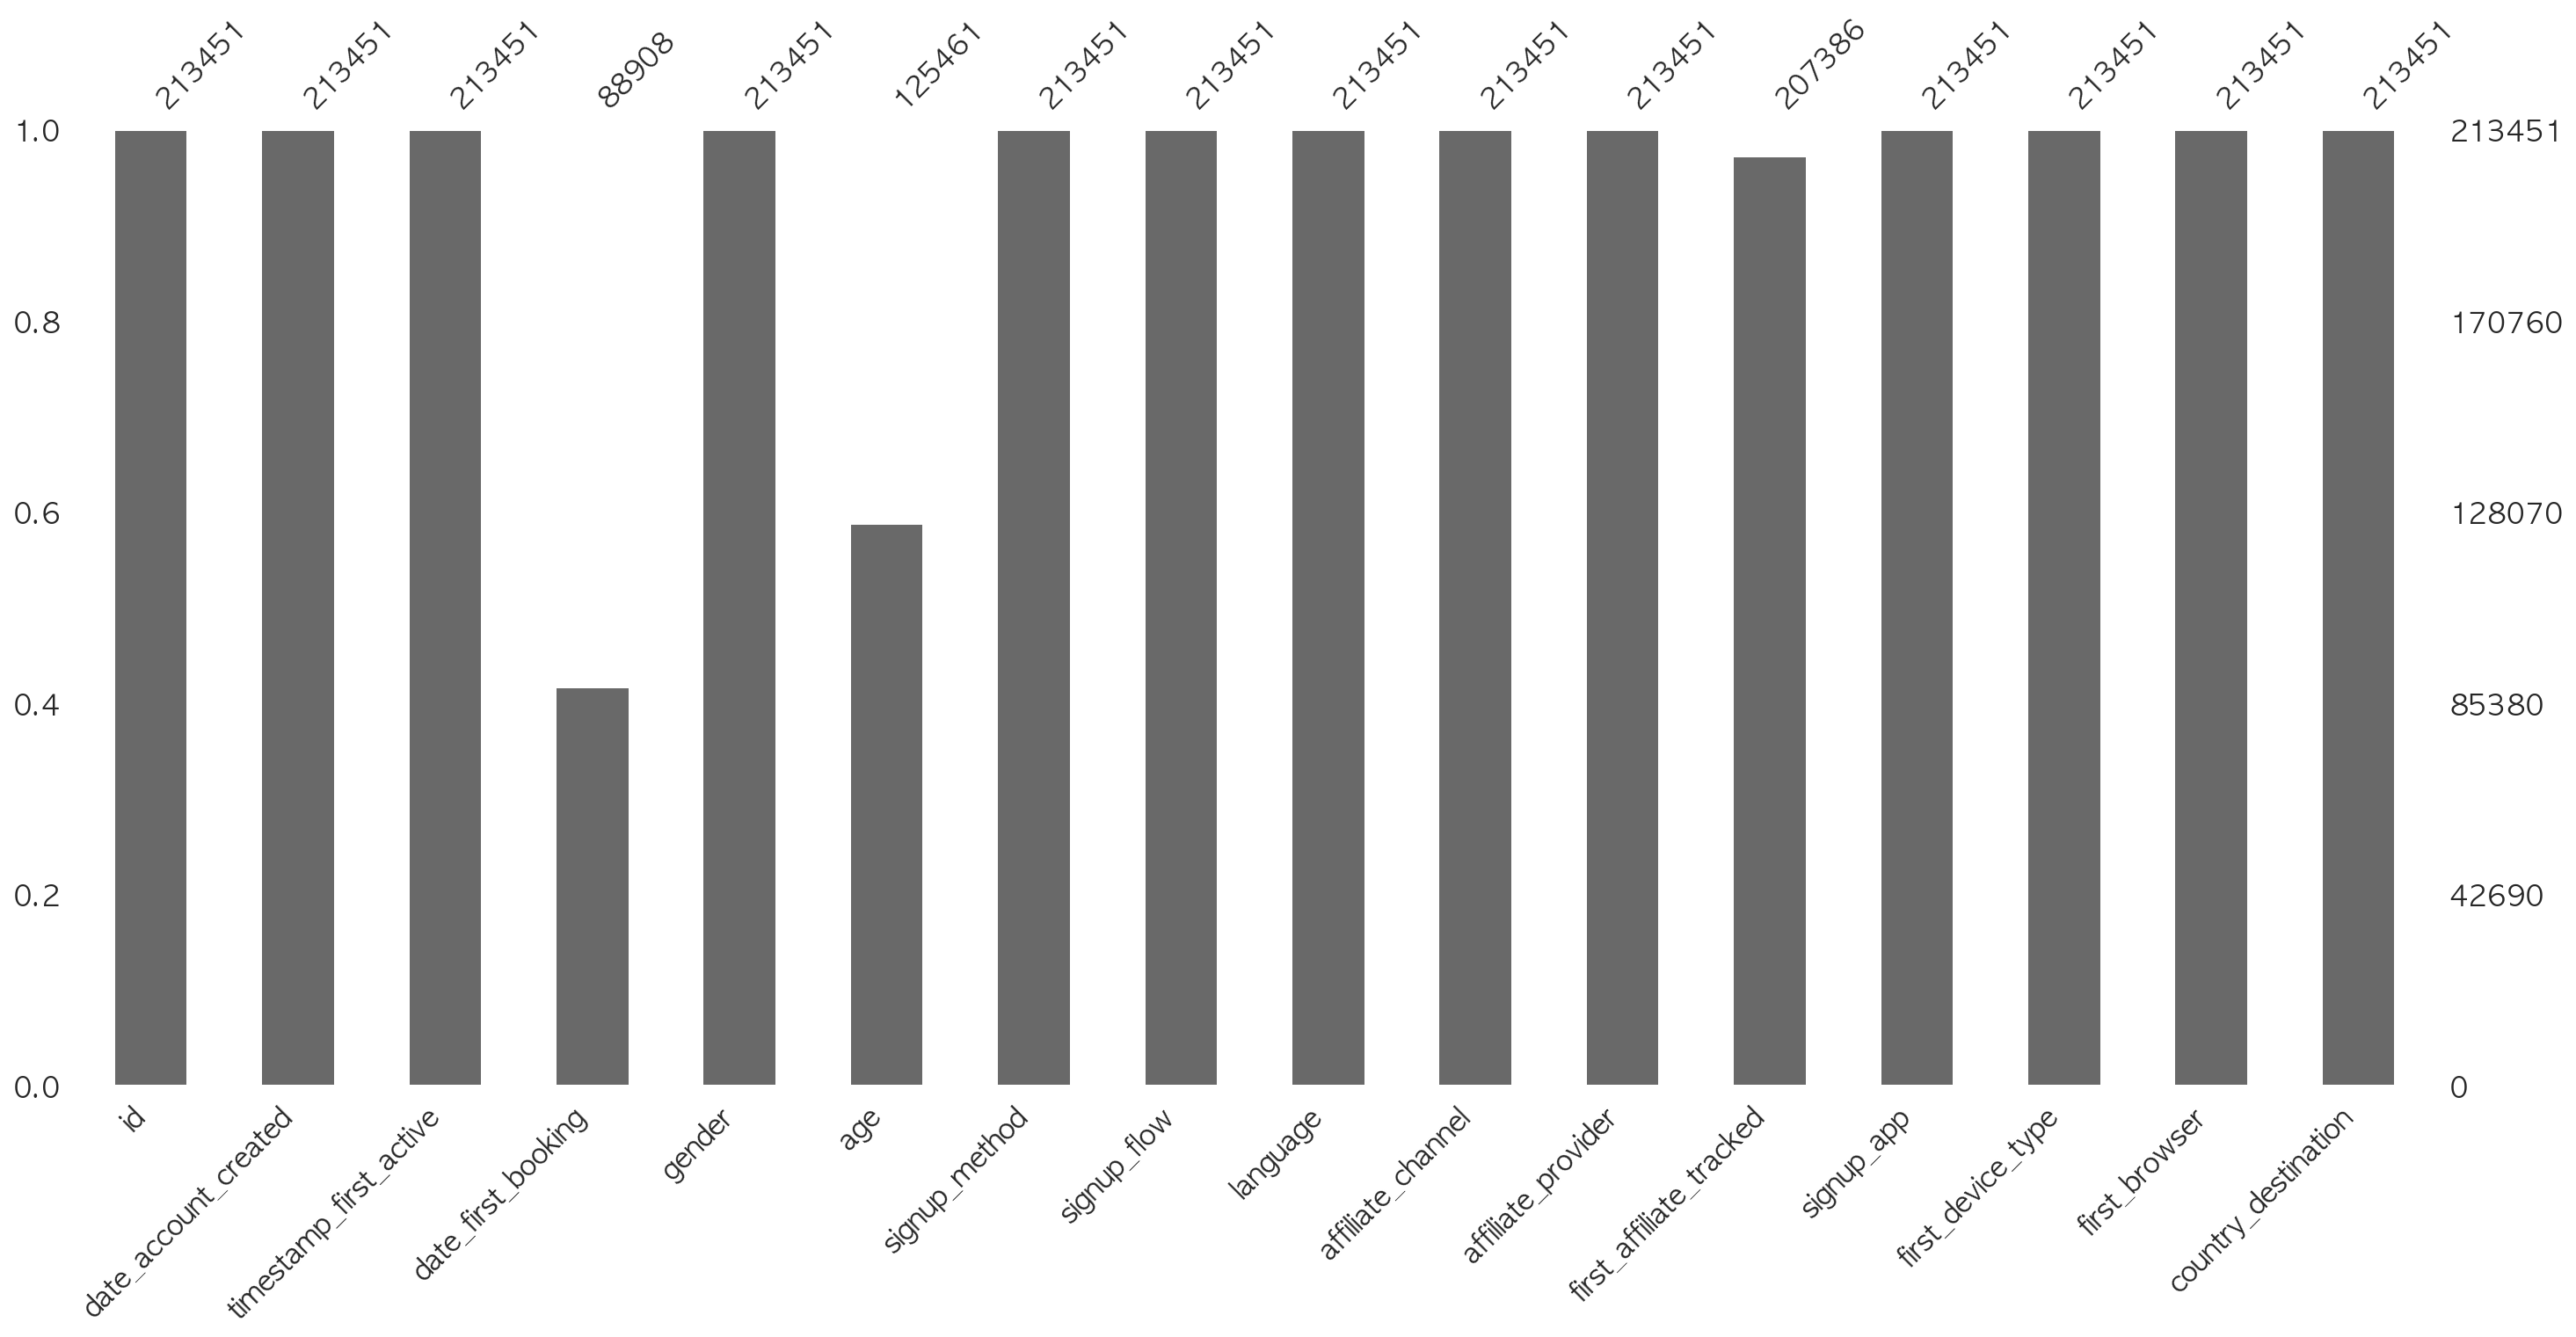

In [34]:
import missingno as msno
msno.bar(df_train)
plt.show()

In [36]:
# 각 컬럼마다 결측치가 얼마나 있는지 찾기
for i in df_train.columns:
    ab = df_train[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

date_first_booking has 124543 null values.

age has 87990 null values.

first_affiliate_tracked has 6065 null values.



In [31]:
# unknown 데이터가 있는 데이터를 결측치로 변경
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [32]:
# first_browser 기준 결측치가 있는 데이터 위주로 출력
df_train[df_train['first_browser'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
11,om1ss59ys8,2010-01-05,20100105051812,NaN,FEMALE,47.0,basic,0,en,other,craigslist,untracked,Web,iPhone,NaN,NDF
12,k6np330cm1,2010-01-05,20100105060859,2010-01-18,NaN,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,NaN,FR
16,2dwbwkx056,2010-01-07,20100107215125,NaN,NaN,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,NaN,NDF
17,frhre329au,2010-01-07,20100107224625,2010-01-09,NaN,31.0,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,NaN,US
18,cxlg85pg1r,2010-01-08,20100108015641,NaN,NaN,NaN,basic,0,en,seo,facebook,NaN,Web,Other/Unknown,NaN,NDF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213429,mhh7b52z44,2014-06-30,20140630232712,NaN,NaN,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,NaN,NDF
213436,6fzrn49sfn,2014-06-30,20140630234113,NaN,NaN,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,NaN,NDF
213437,r0jq0devgy,2014-06-30,20140630234243,NaN,NaN,NaN,basic,23,en,direct,direct,untracked,Android,Android Tablet,NaN,NDF
213438,v5lq9bj8gv,2014-06-30,20140630234429,NaN,NaN,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,NaN,NDF


In [33]:
# country_destination 기준 결측치가 없는 데이터 기준으로 출력 
df_train[df_train['country_destination'].notnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,NaN,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,NaN,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,NaN,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


- Train 데이터 셋에서 결측치가 없는 컬럼들 
    - 1. id
    - 2. date_account_created
    - 3. timestamp_first_active
    - 4. signup_method
    - 5. signup_flow
    - 6. language
    - 7. affiliate_channel
    - 8. affiliate_provider
    - 9. signup_app
    - 10. first_device_type
- 결측치가 있는 컬럼들
    - 1. date_first_booking
    - 2. gender
    - 3. age
    - 4. first_affiliate_tracked
    - 5. first_browser 

In [37]:
# age 내용 확인
df_train['age'].value_counts()

30.0      6124
31.0      6016
29.0      5963
28.0      5939
32.0      5855
          ... 
1925.0       1
2008.0       1
1995.0       1
1952.0       1
1942.0       1
Name: age, Length: 127, dtype: int64

In [34]:
# 연령대가 120세 초과 인 데이터만 추출
df_train[df_train['age'] > 120]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,NaN,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197386,99y83scsje,2014-05-31,20140531031949,2014-05-31,FEMALE,1938.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,IE,US
198888,io7z9esqaj,2014-06-03,20140603074958,2014-10-09,MALE,1924.0,facebook,23,en,direct,direct,untracked,Android,Other/Unknown,NaN,US
206249,zmlbfc7cso,2014-06-17,20140617230607,2014-06-20,FEMALE,1947.0,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome,US
208819,0dn4tfj6gw,2014-06-22,20140622214130,NaN,FEMALE,1949.0,basic,0,en,direct,direct,untracked,Moweb,Android Phone,Chrome Mobile,NDF


- 나이가 120 세를 넘는 데이터가 있음 (현재까지 가장 나이가 많은 사람은 117세), 나머지 이상하게 되어있는 (예:2000, 1977 등) 데이터들은 오염된 데이터이므로 제거가 불가피해 보임. (해당 데이터들을 null 값으로 대체!)

In [35]:
# 120을 초과한 데이터들을 결측치로 처리 
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 120 else x)

## 2. 추론 통계 

### 2-1. 에어비앤비 예약에 대한 성별 선호도
- 해당 섹션에서는 통계 도구를 적용하여 우리가 다루는 데이터의 종류에 대한 추론과 통찰력을 얻고 데이터 세트의 다양한 기능 간의 관계를 분석함.
- 먼저 특정 국가에 대한 성별 선호도가 있는지 확인할 예정. 즉 성별의 차이가 에어비앤비에 처음 예약하려는 목적지 국가에 영향을 미치는가? 해당 질문에 답을 하려면 성별과 목적지 국가라는 두 가지 범주 간의 관계를 테스트 해야함. (목적지 국가의 수가 다변량이기 때문에 카이 제곱을 이용해서 test)
- 시작하기 전 다음과 같이 몇 가지 사항을 **가정**해봄.
    - 1. 남성 또는 여성으로 등록한 사용자만 고려할지? (**알수 없는 성별과 기타 성별은 포함하지 않음**)
    - 2. 에어비앤비를 예약해본 적 없거나 등록되지 않은 국가를 고려할지? (**NDF 및 기타는 고려하지 않음.**)

In [36]:
# 위에서 말한 가정대로 알수 없는 성별과 기타성별, NDF와 기타 국가를 뺀 순수 데이터만 추출 
df_info = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other' ) & 
                  (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_info = df_info[['id', 'gender', 'country_destination']]
df_info

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US
...,...,...,...
213412,a1rvlsdijt,FEMALE,US
213439,msucfwmlzc,MALE,US
213441,omlc9iku7t,FEMALE,ES
213443,0k26r3mir0,FEMALE,US


In [37]:
# 성별 데이터 확인
df_info['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [38]:
# 목적지 국가데이터 확인 
df_info['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

- 가설 검증 - 가설 검정을 위해 다음과 같이 정의
    - 1. 영가설 : 선호하는 국가와 성별은 관게가 없을 것이다.
    - 2. 대립가설 : 선호하는 국가와 성별은 관계가 있을 것이다.
    - 유의 수준을 α를 0.05로 가정 (잘못된 의사결정을 내리 확률이 0.05라는 것을 의미)
    - **유의수준** : 가설검정에서 귀무가설이 실제로 참일 때 귀무가설에 대한 판단의 오류수준(잘못을 기각할 확률)을 말함. **α**는 표본을 추출하기 이전에 설정하여 표본에서 얻은 결과가 우리의 선택에 영향을 미치지 않도록 한다. 보통 표본통계치가 나올 확률 p가 0.05 또는 0.01인 점을 유의수준으로 설정함.

In [39]:
# gender를 기준으로 country_destination를 count하여 피벗테이블로 셋팅
observe = df_info.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
observe.columns.name
observe = observe.set_index('gender')
observe

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [40]:
# 카이제곱, P-value 계산
chi2, p, dof, expected = stats.chi2_contingency(observe)

In [41]:
# 카이제곱 계산 결과 (검정 통계량)
chi2

116.87183139602567

In [42]:
# 자유도
dof

9

In [43]:
# p-value = 0 (유의수준인 0.05보다 낮음)
p

5.830126955071572e-21

- 우리가 얻은 P value는 우리가 선택한 유의 수준보다 적음. 따라서 귀무가설을 기각 (선호하는 국가와 성별은 관계가 있다.)

### 2-2. 가입 환경 설정 
- 이번에는 가입 방법과 가입 디바이스 간의 관계를 알아봄. 데이터에서는 대부분 사용자가 기본환경(에어비엔비) 또는 페이스북을 통해 가입한다는 것을 알 수있고, 가입 디바이스로는 데스크톱 브라우져, 모바일 브라우저 및 앱을 사용하여 로그인 함.
- 기기 유형 (모바알 혹은 컴퓨터)이 에어비앤비 가입에 영향을 미치는지 알아보기 위해 특정 가설을 설정 
    - 1. Google 가입 방법의 수가 적기때문에 해당 사항은 무시
    - 2. ios, 안드로이드 모바일 웹은 모바일 장치 유형으로 간주 

In [44]:
# 가입 방법에 구글은 제외, device 컬럼을 추가하여 web-> computer, 나머지는 mobile로 구분하기
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer
...,...,...,...,...
213446,zxodksqpep,basic,Web,Computer
213447,mhewnxesx9,basic,Web,Computer
213448,6o3arsjbb4,basic,Web,Computer
213449,jh95kwisub,basic,iOS,Mobile


In [45]:
# 가입 방법 데이터 확인 
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [46]:
# 디바이스 데이터 확인 
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

- 가설 검증
    - 영가설 : 기기유형과 가입방법 간에는 관계가 없다.
    - 대립가설 : 기기유형과 가입방법 간에는 관계가 있다. 
    - 유의 수준을 α를 0.05로 가정
- 위와 같이 카이제곱 검증과 Z 검증을 사용하여 동일한 가설 검증을 할 예정

In [47]:
# 피벗테이블 
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method',aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


In [48]:
# 카이제곱 검증
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [49]:
# 카이제곱 결과 
chi2

0.07183824273421707

In [50]:
# 자유도 
dof

1

In [51]:
# p_value 결과 (유의수준인 p-value보다 높음)
p

0.7886788661023779

- P 값은 선택된 유의 수준보다 높게 나옴, 따라서 귀무가설을 기각할 수 없음.(장치유형과 가입방법간에 관계가 있지 않음.)
- 그렇다면 Z-검증을 사용해여 얻은 결과와 P 값을 비교해보겠음.
    - **Z-검증(단일표본검증)** : 모집단 분산을 아는 경우 표준 정규분포를 사용하여 검증함.(만약 모집단 분산을 모르는 경우 T-검증을 사용함)
    - 과정 : 모집단 분산 활용 -> 표준정규분포 활용 -> 귀무가설 검증 

In [52]:
# 두가지 샘플 유의성 검증 : 이제 비율에 대한 두 개의 표본 유의성 검증을 사용해서 동일한 가설 검증을 수행
df_signup.loc['Total'] = [df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [53]:
# 페이스북 모바일 이용량 비율과 페이스북 이용량 표준편차

# 페이스북 모바일 이용률 (8528(페이스북 모바일 이용수) / 60008(페이스북 전체 이용수))
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook'] 

# 페이스북 전체 이용량 표준편차 [8528*(1-0.142)**2 + 51480*(1-0.142)**2] / 60008
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) \
         + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2) 
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.3491674188640724)

In [54]:
# 에어비앤비 모바일 이용량 비율과 에어비앤비 이용량 표준편차

# 에어비앤비 모바일 이용률 (21660(에어비앤비 모바일 이용수) / 152897 (에어비앤비 전체 이용수))
bagic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']  

# 에어비앤비 전체 이용량 표준편차 [21660*(1-0.142)**2 + 131237*(1-0.142)**2] / 152897
bagic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - bagic_prop) ** 2) \
         + df_signup.loc['Computer', 'Basic'] * ((0 - bagic_prop) ** 2) 
bagic_std = np.sqrt(bagic_std/df_signup.loc['Total', 'Basic']) 

bagic_prop, bagic_std

(0.14166399602346677, 0.34870518816635054)

In [55]:
h0_prop = 0

# 이용률 차이 계산 (페이스북 모바일 이용률 - 에어비앤비 모바일 이용률)
prop_diff = fb_prop - bagic_prop

# 각각 전체 이용률 (에어비앤비 모바일이용량 + 페이스북 모바일이용량)/(에어비앤비 사이트이용량 + 페이스북 사이트이용량)
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic']\
                                                                             + df_signup.loc['Total', 'Facebook']) 

# 0.16*(1-0.16) * (1 / 152897 + 1 / 60008)
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])

# 루트 var_diff
sigma_diff = np.sqrt(var_diff)

# 결과 
prop_diff, sigma_diff

(0.0004503887252333971, 0.001680388342245922)

In [56]:
# z 검정 : {\displaystyle {\overline {X}}} 표본평균,{\displaystyle \mu }\mu 는 모 평균, SE는 표준오차
z = (prop_diff - h0_prop) / sigma_diff
z

0.2680265709481359

In [57]:
# p-value (유의수준인 0.05보다 높음)
p = (1-stats.norm.cdf(z))*2
p

0.7886788661023794

- 얻은 P값이 유의수준보다 높게 나타남. 따라서 귀무가설을 기각할 수 없음(기기 유형과 가입 방법 간에는 관계가 없다.)
- 또한 표본 유의성 검증과 카이제곱 유의성 검증에서 얻은 것이 p값과 정확히 일치, 이제 수행된 통계 분석을 기반으로 결과를 요약하고 발표할 수 있는 위치에 있음.

- **결론**
    - 성별과 목적지 국가는 관계가 있음. (성별은 목적지 국가에 영향을 미침.)
    - 기기 유형과 가입 방법간에는 관계가 없음. (두 변수는 서로 독립적임.)
    - 카이제곱 유의성 검증과 두 표본 유의성 검정 결과는 정확히 동일함.

## 3. 데이터 탐색 (EDA)
- 이번 파트는 데이터를 시각화하여 요약하고 새로운 인사이트 도출.
- 다양한 국가의 연령 및 성별 등을 시각화

### 3-1. 국가 통계

In [58]:
# 한글 설정
from matplotlib import font_manager, rc   
plt.rcParams['axes.unicode_minus'] = False   # 그래프 한글 설정을 위해 matplotlib에서 rc 불러오기 (한글 깨짐 현상을 막아줌)

import platform
if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

sns.set_style('darkgrid') # seaborn 그래프 background 회색으로 설정 
sns.set_context('talk') # 컨텍스트 매개 변수를 변경 플롯의 레이블에 대한 기본 글꼴 크기를 제어하는데 사용
sns.set(font_scale = 1) # 그래프 x축, y축 폰트 작게 설정 

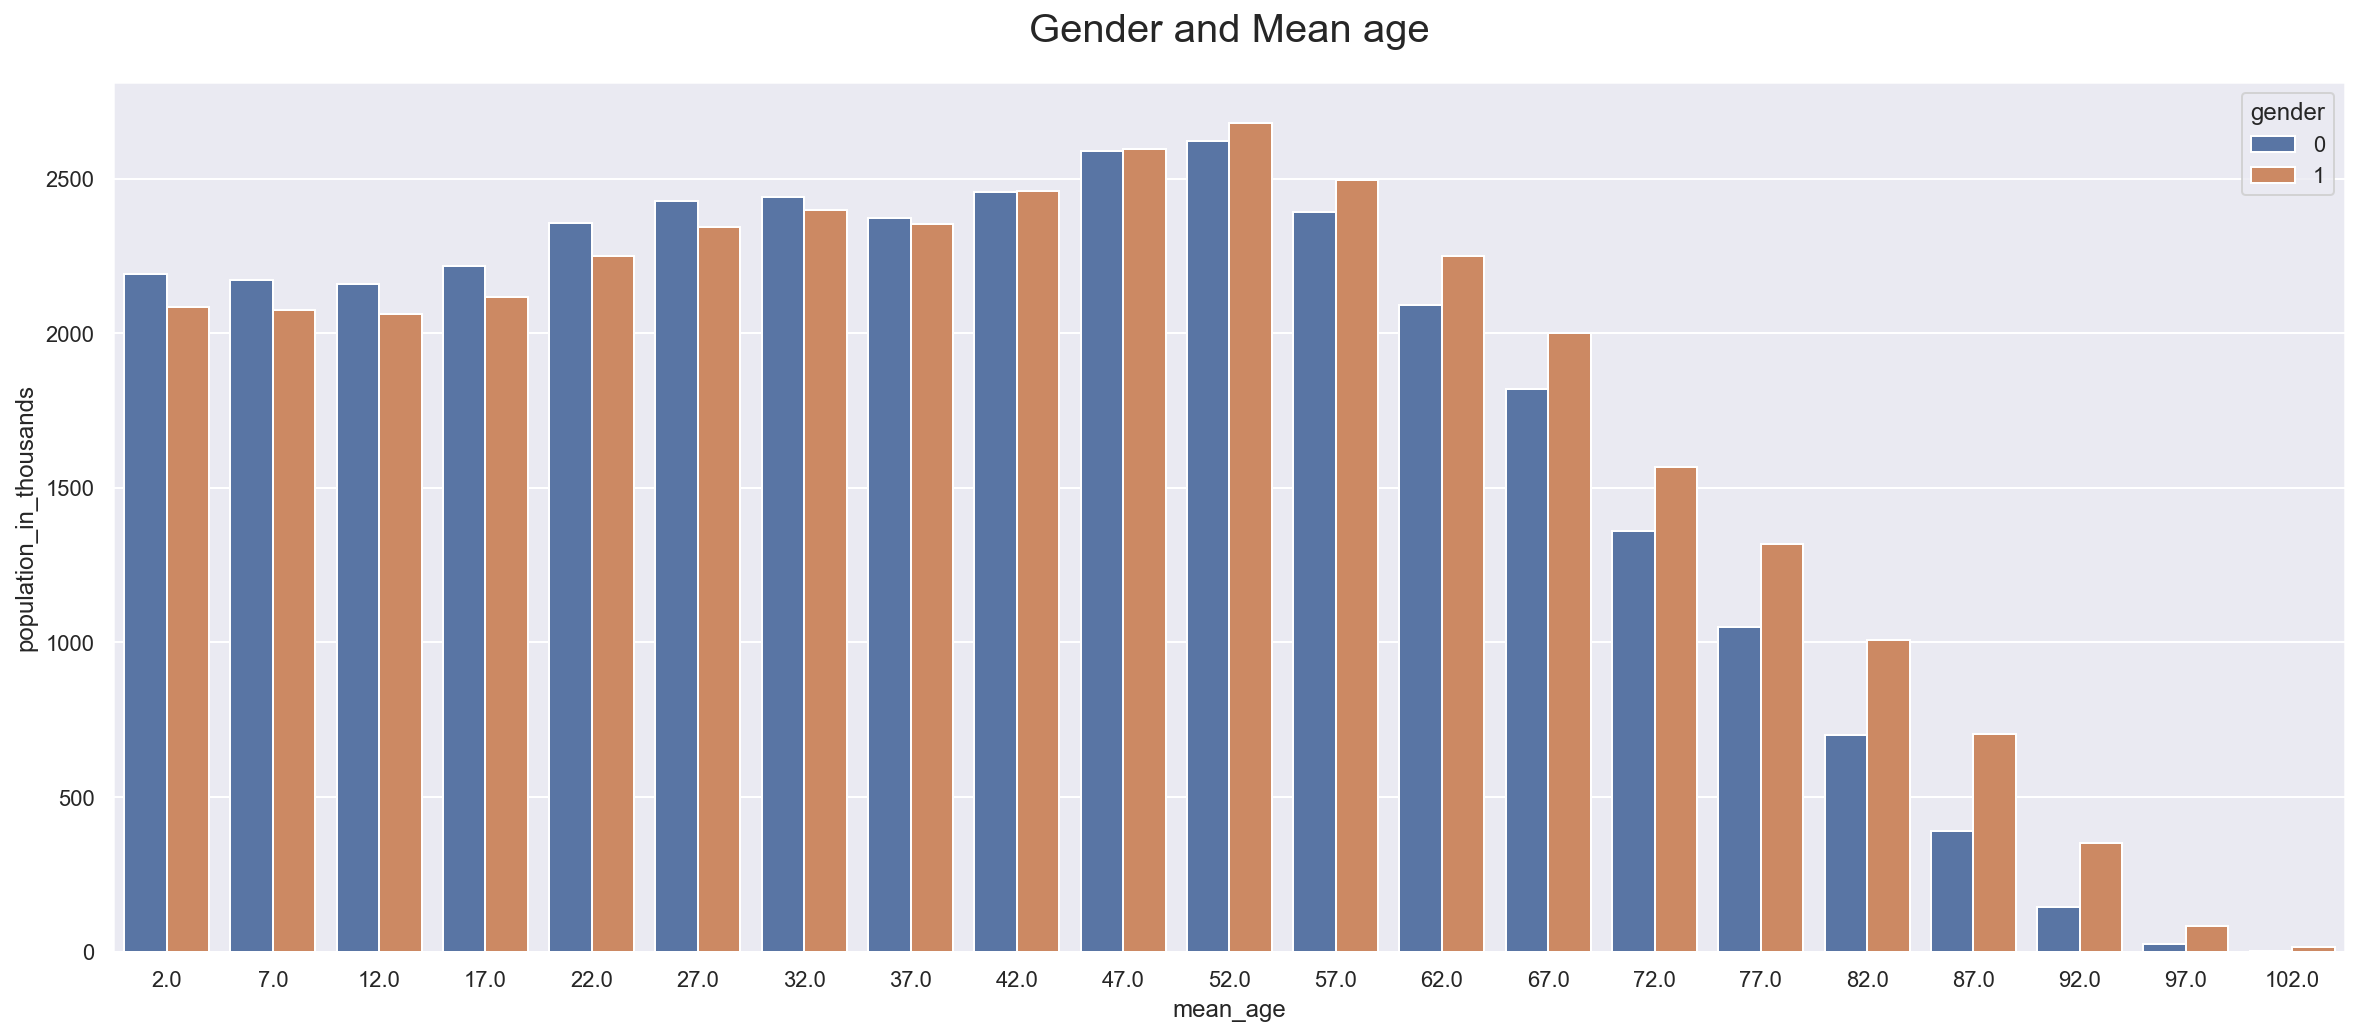

In [59]:
# 성별 대비 평균나이 분포 - 0:남자, 1:여자
plt.figure(figsize=(20,8))
plt.title("Gender and Mean age", fontsize=20, pad=20)
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, ci=None);

- 해당 표는 각국의 인구를 나타냄. 
- 표의 분포를 보아 가장 큰 평균 연령대 그룹은 47세와 52세인 사람들.
- 가장 많은 연령대는 중년층 그 다음 청년층, 마지막으로 노인층이 그 뒤를 따름.
- 청년층과 중년층의 인구수는 비슷해보이나, 노년층(여기서는 62세부터)의 인구수는 감소하고 있음을 나타냄.
- 주목할 점은 청년층은 남성의 비율이 높으나, 평균연령이 증가함에 따라 중년층 및 노인층의 여성의 비율이 높다. (실제로 여성은 남성보다 오래 산다.)

### 3-2. 국가별 인구수 통계

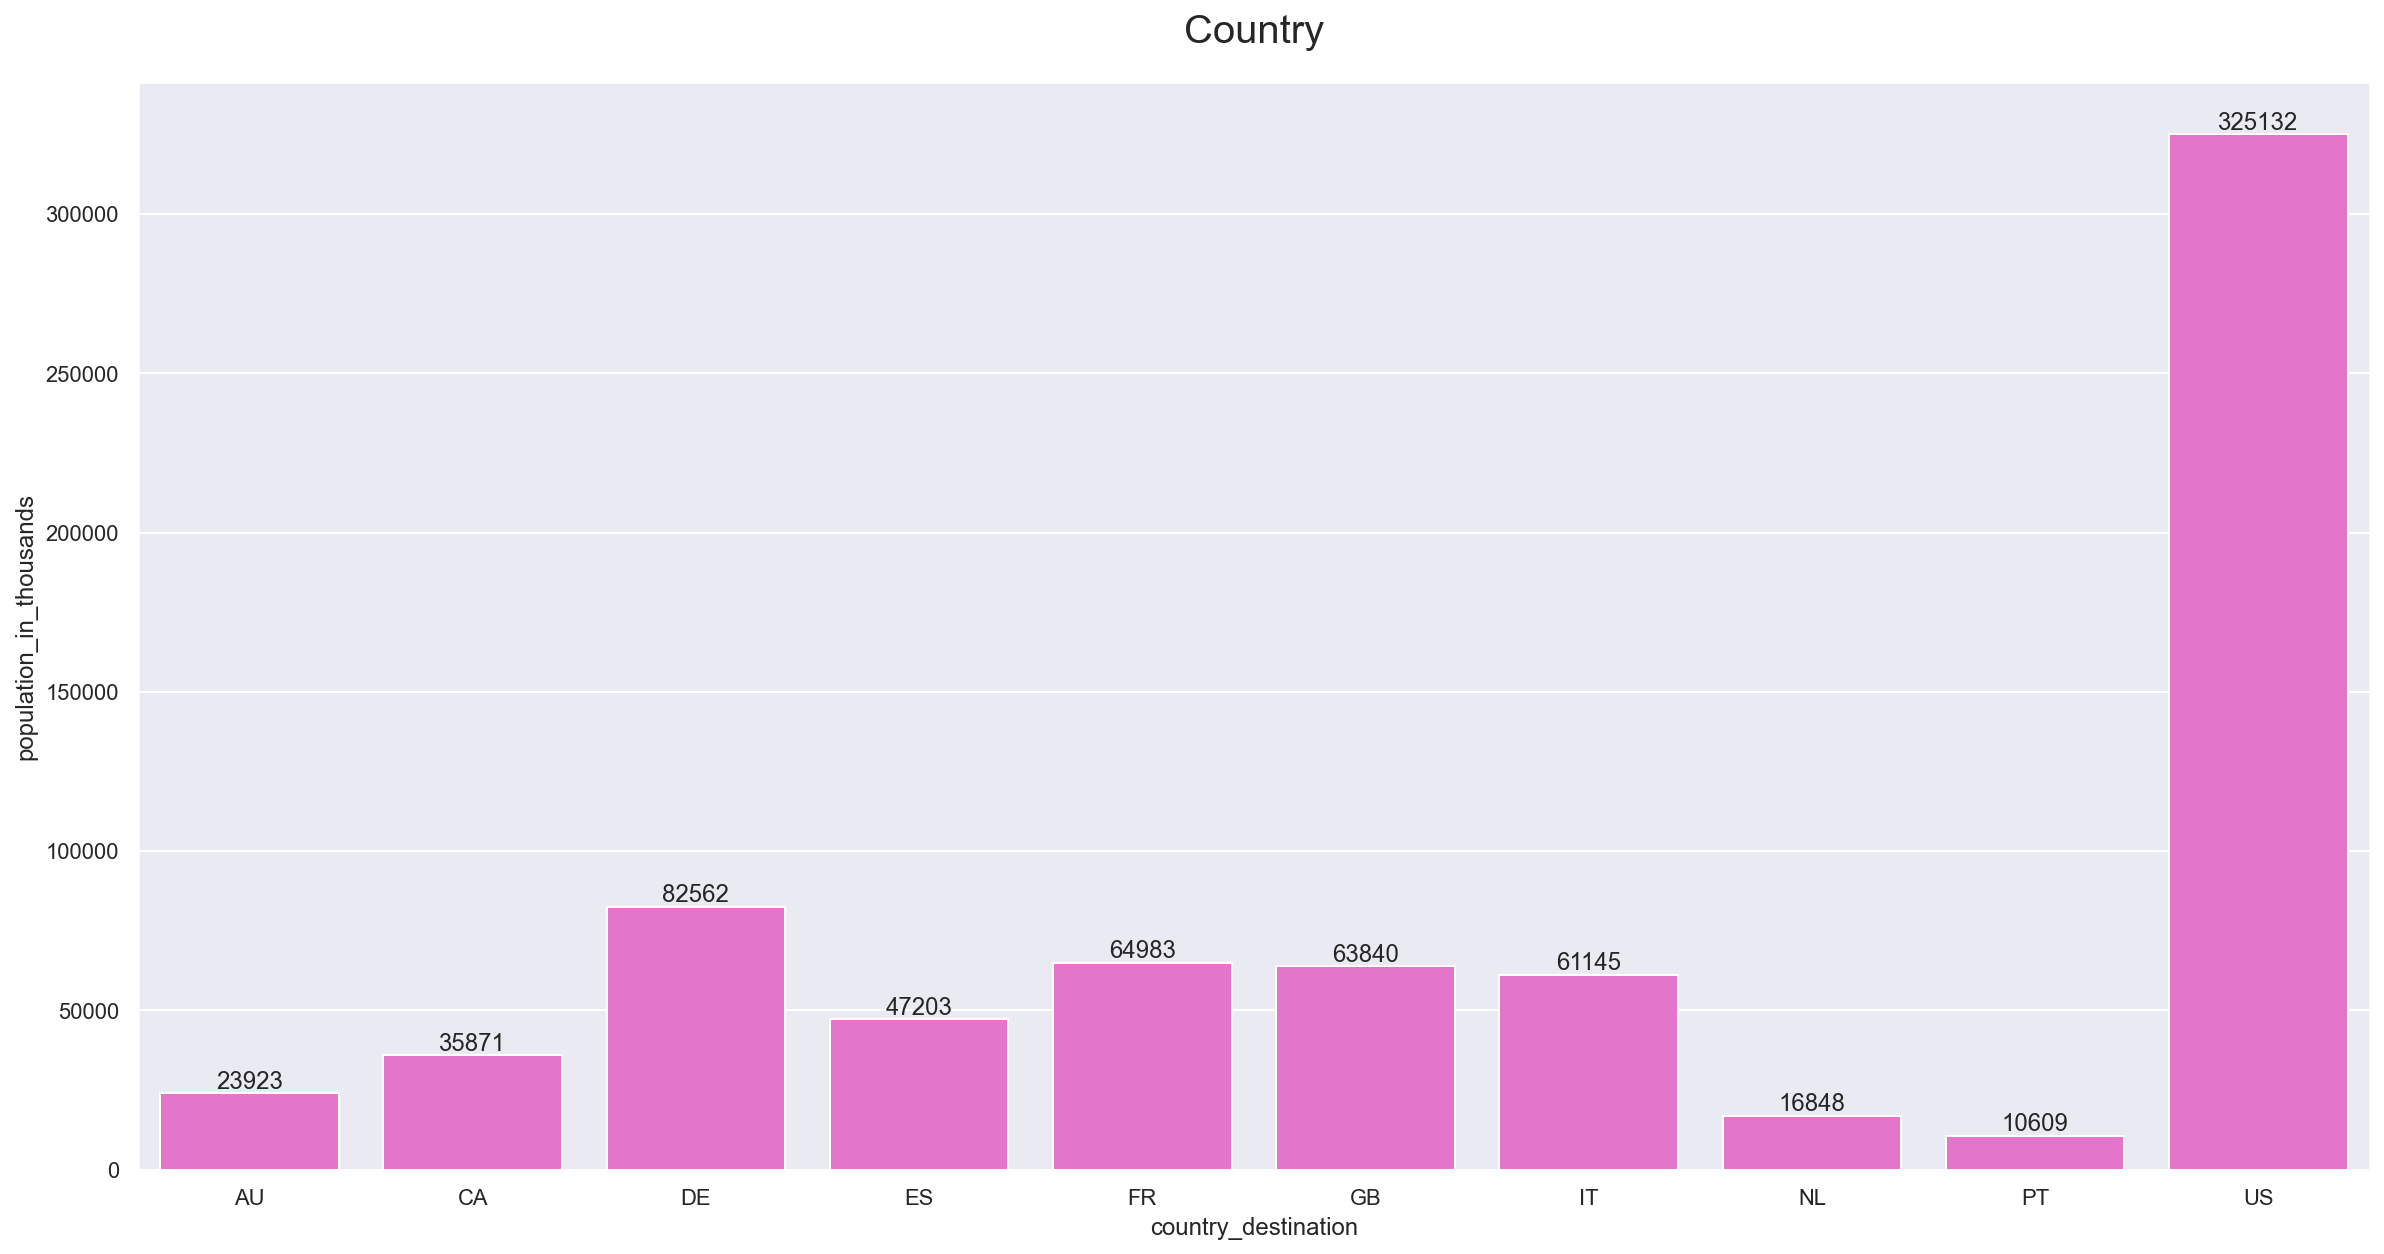

In [60]:
plt.figure(figsize=(20,10))
plt.title("Country", fontsize=20, pad=20)
pop_stats = df_agb.groupby('country_destination')['population_in_thousands'].sum()
sns.barplot(x=pop_stats.index, y=pop_stats, color=sns.color_palette("husl", 9)[8]);

for i in range(pop_stats.shape[0]):
    count = pop_stats[i]
    strt = "{:0.0f}".format(10*count / pop_stats.shape[0])
    plt.text(i, count+1500, strt, ha = "center")

- 미국은 3억이상의 인구를 가졌으며, 가장 인구가 많은 국가. 
- 목록에 있는 다른 모든 국가의 인구는 1억 미만 

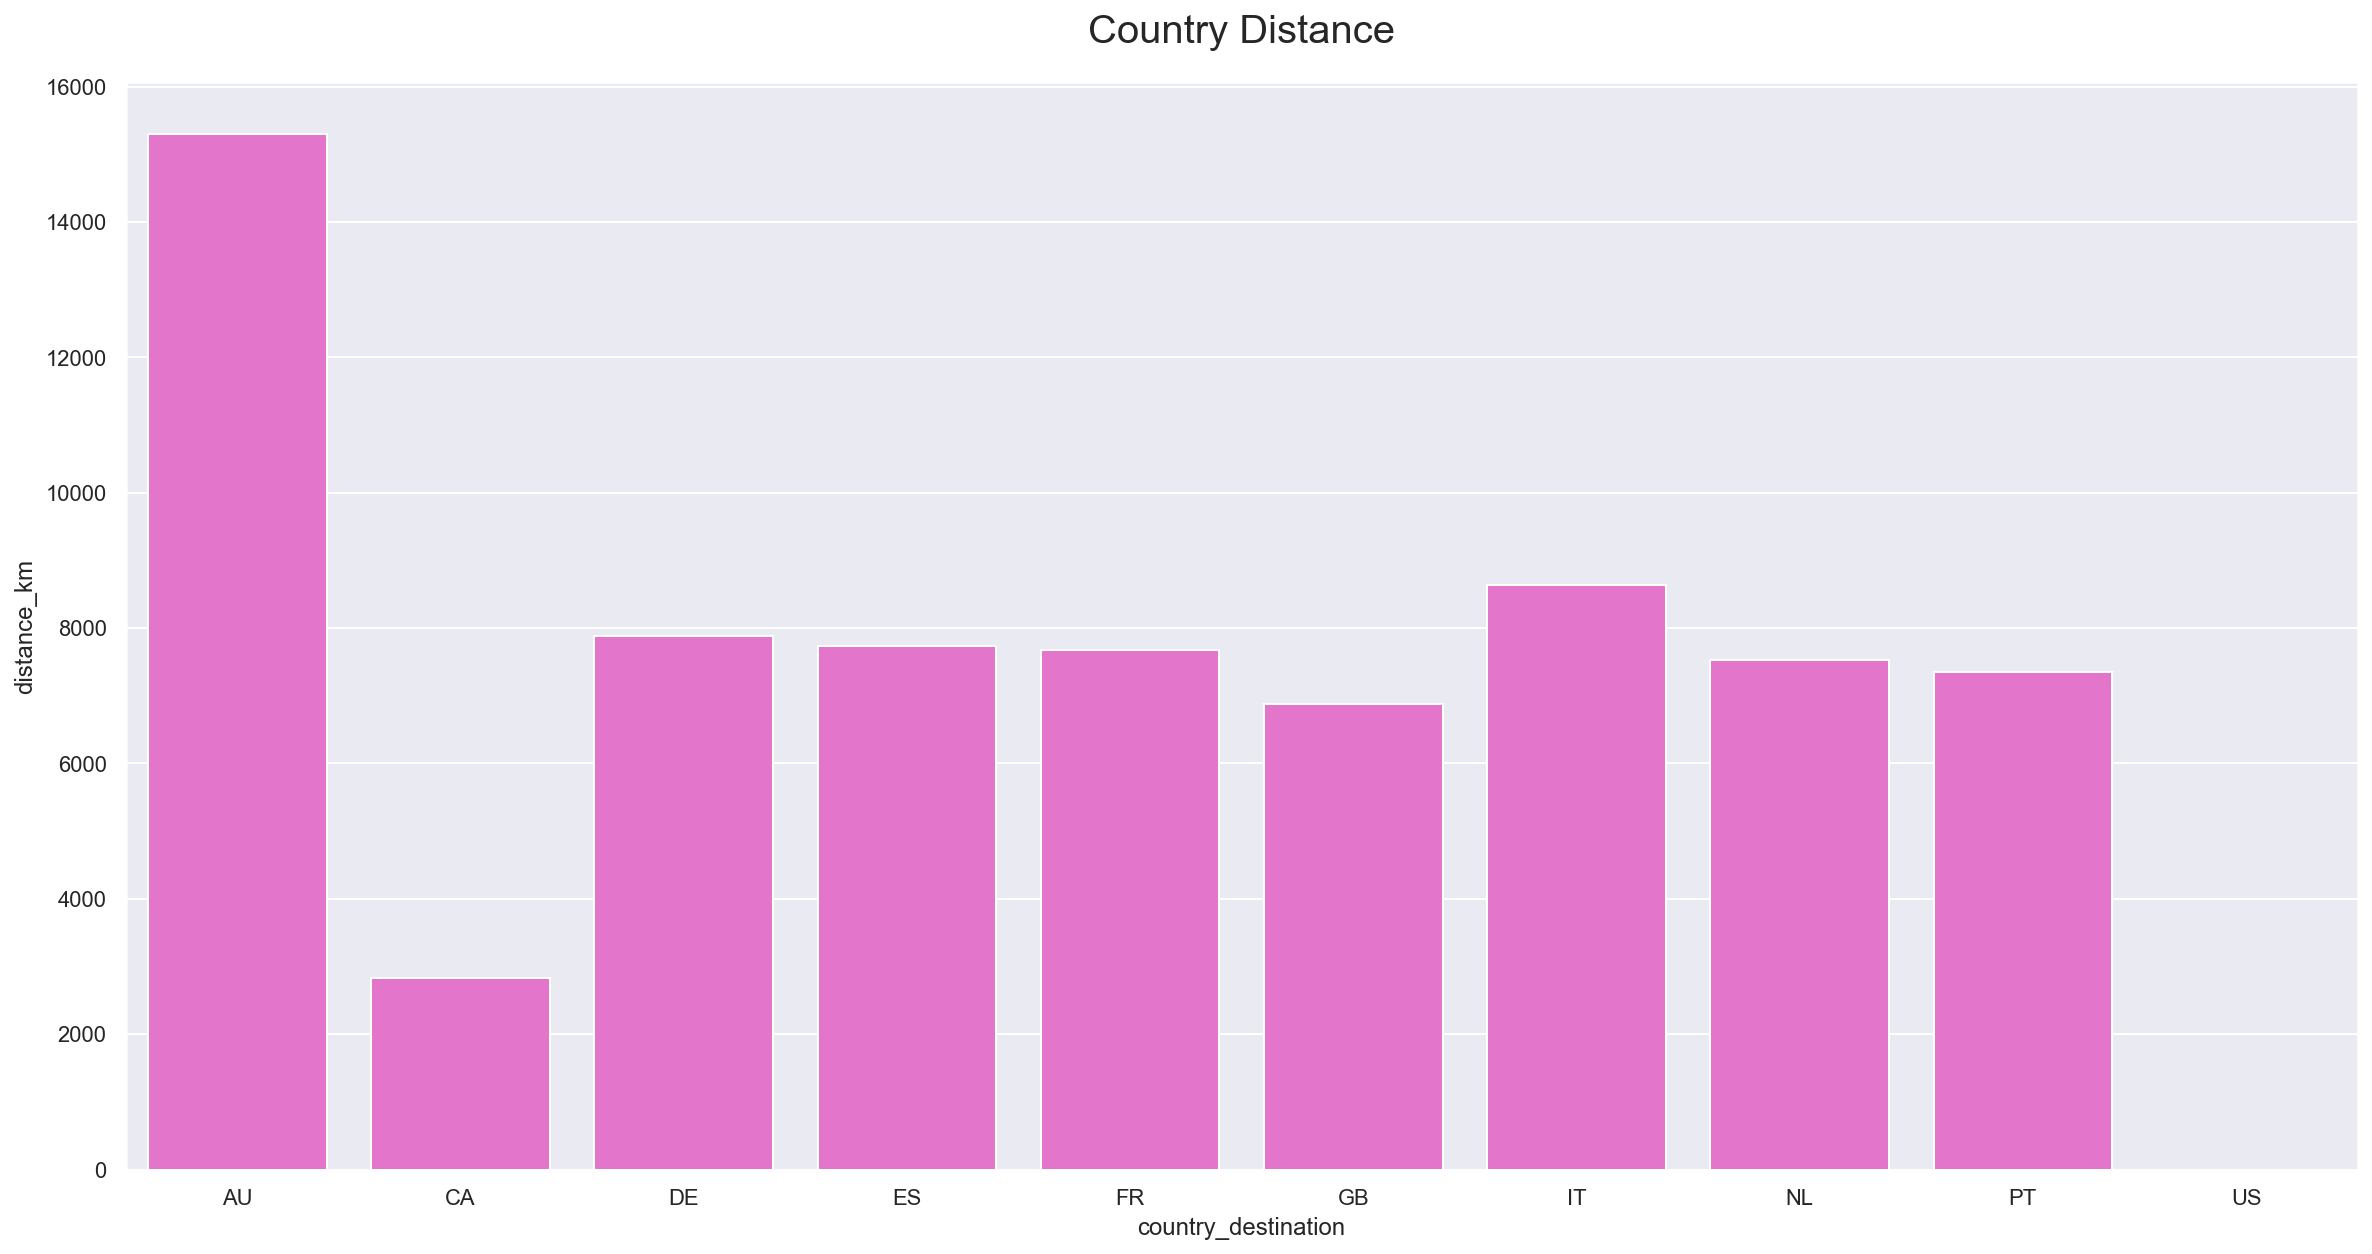

In [61]:
# 목적지 국가 (미국)에서  국가까지의 거리에 대한 그래프 표현
plt.figure(figsize=(20,10))
plt.title("Country Distance", fontsize=20, pad=20)
sns.barplot(x='country_destination', y='distance_km', data=df_con, color=sns.color_palette("husl", 9)[8]);

- 미국 기준으로 가장 거리가 먼 곳은 호주

In [62]:
# 예약 빈도가 많은 국가 
country_popularity = df_train[(df_train['country_destination'] != 'NDF') & 
                              (df_train['country_destination'] != 'other')]['country_destination'].value_counts()

In [63]:
# 국가간의 거리 
country_distance = pd.Series(df_con['distance_km'])
country_distance.index = df_con['country_destination']

In [64]:
# 언어 유사도 
language_distance = pd.Series(df_con['language_levenshtein_distance'])
language_distance.index = df_con['country_destination']

In [65]:
# 국가 면적 
country_area = pd.Series(df_con['destination_km2'])
country_area.index = df_con['country_destination']

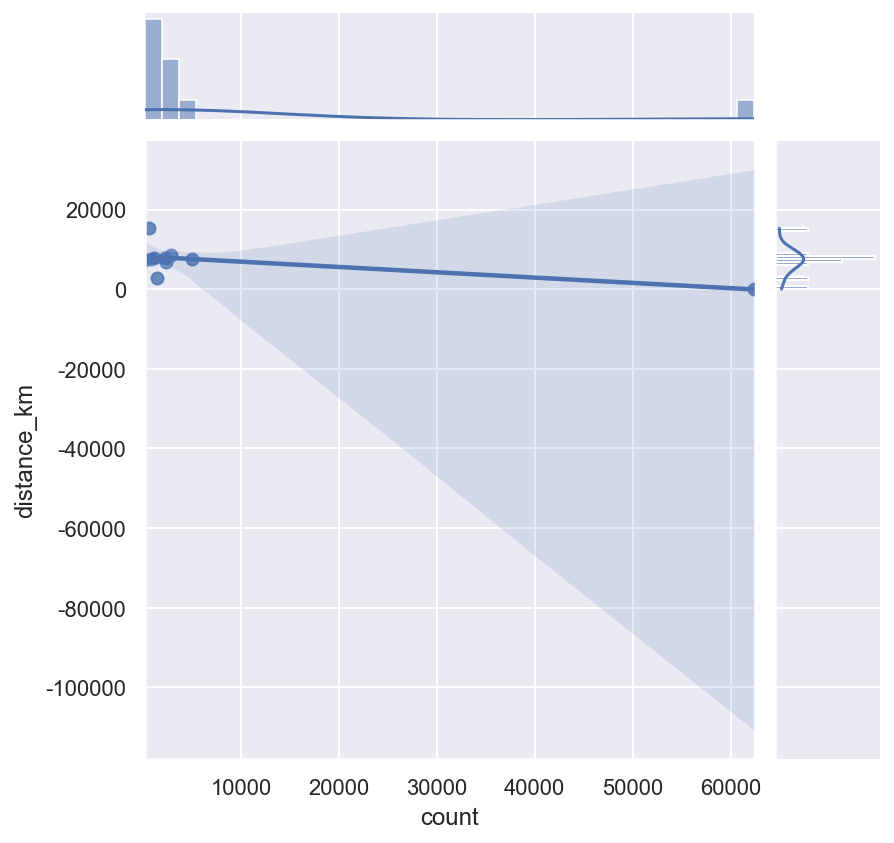

In [66]:
# 국가간의 거리사이의 상관관계 표시 
df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp, kind='reg')
plt.show()

- 예약 빈도와 해당 국가의 거리 사이에 산점도 구성 
- 사람들은 어느나라 보다 미국에서 예약하는 것을 선호 (당연히 기준이 미국인이니 그러지 않을까?)
- 국가의 거리가 클수록 예약할 가능성이 적다고 볼 수 있음.

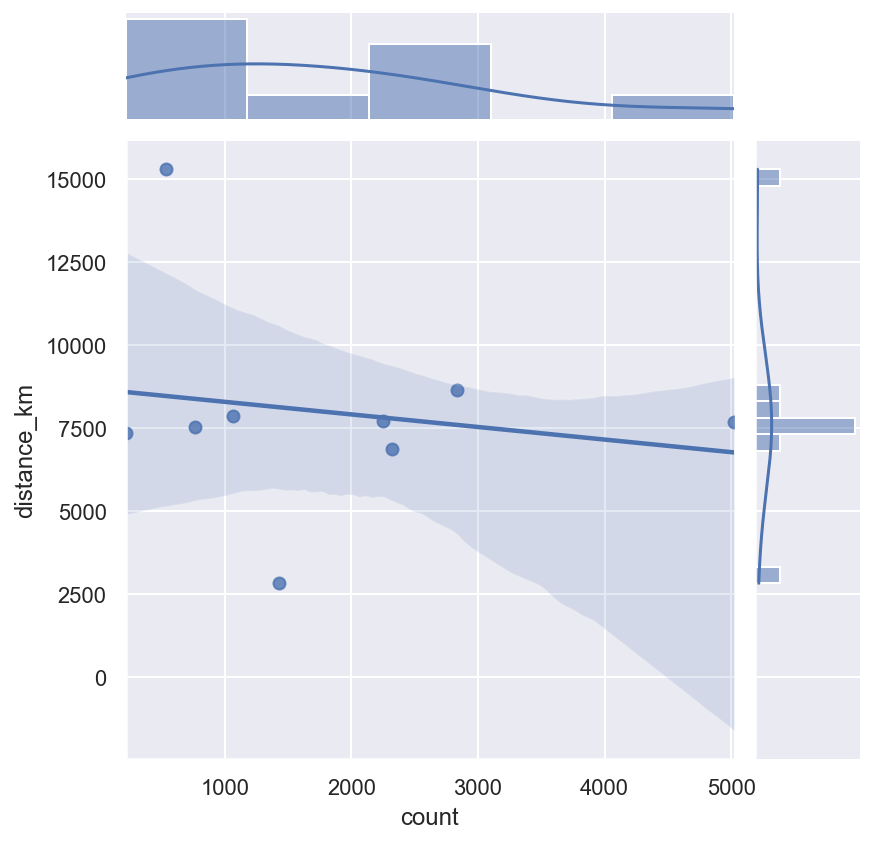

In [67]:
# 그렇다면 미국을 빼고 한번 살펴보자
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'), kind='reg');

- 그렇게 차이는 나지 않아 보이지만 미국의 예약수를 빼더라도 일부 다른나라 목적지와의 상관관계가 나타냄.

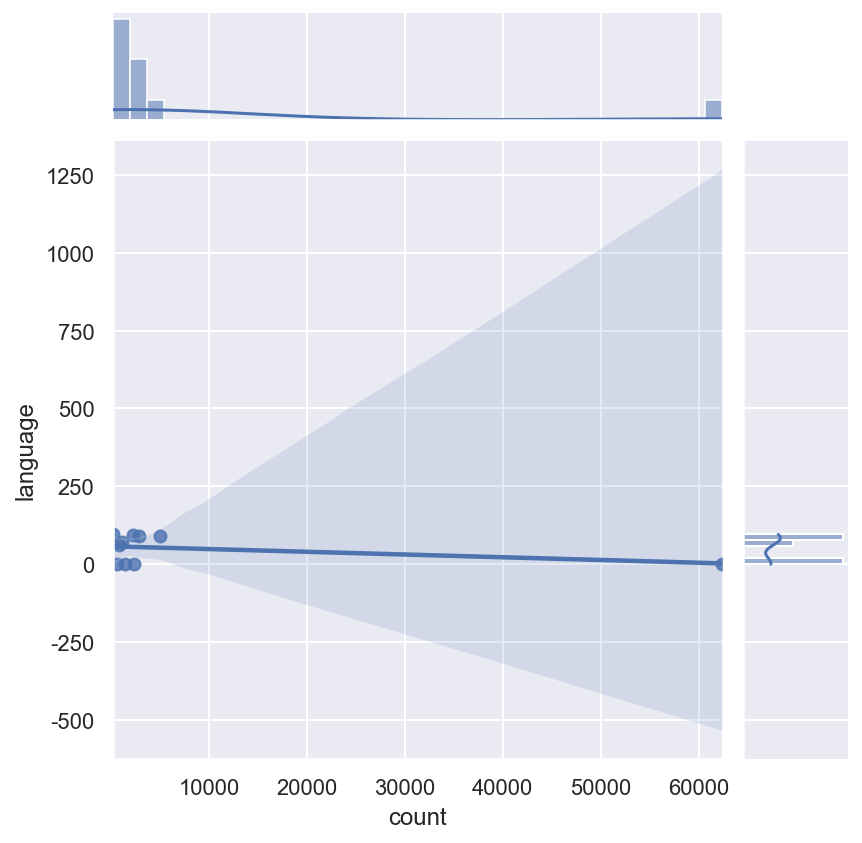

In [68]:
# 국가와 사용되는 언어간의 상관관계
sns.jointplot(x='count', y='language', data=df_dp, kind='reg');

- 다음으로, 특정 국가에서 사용되는 언어가 해당 국가의 예약 수에 영향을 미치는지 확인.
- 영어를 사용하는 나라를 선호한다는 것을 시사.

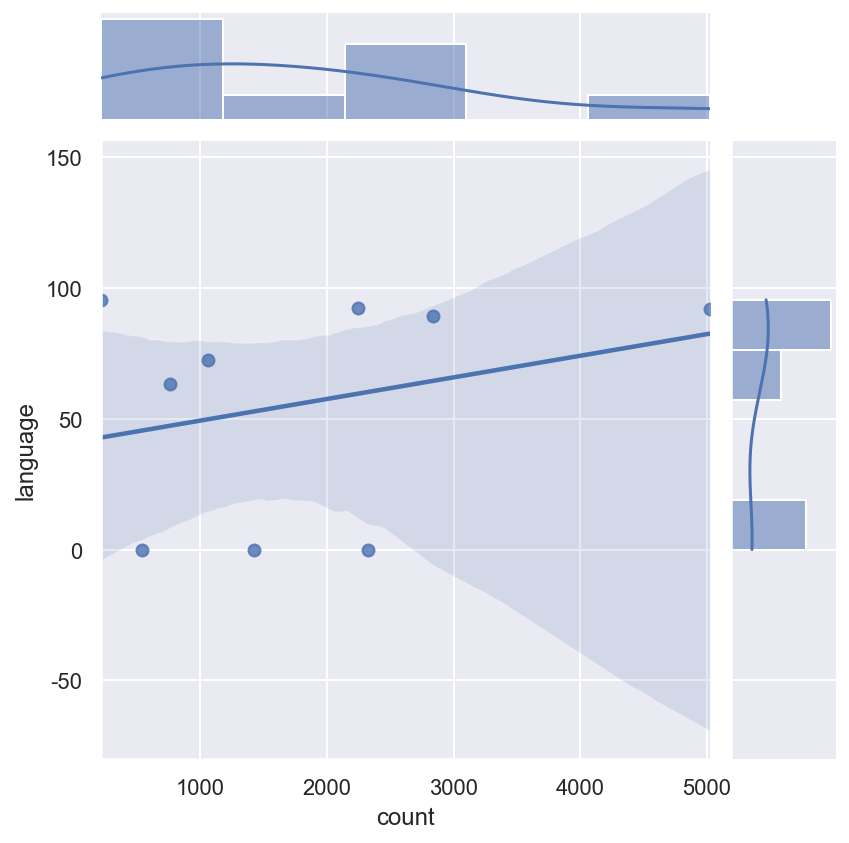

In [69]:
# 국가와 사용되는 언어간의 상관관계 (미국제외)
sns.jointplot(x='count', y='language', data=df_dp.drop('US'), kind='reg');

- 미국이 국가 명단에서 삭제되었을 때 실제로 언어 거리와 예약 빈도 사이에 긍정적인 상관관계가 있음. 하지만 언어와 크게 상관이 없는 것 처림 보인다.
    - 정리
    - 언뜻 보기에, 사람들이 해외 여행을 하는동안 다른 언어를 가진 나라들을 선호한다는 것을 암시할 수 있음.
    - 유럽이 미국인들에게 매우 인기 있는 여행지이고 그들은 캐나다나 호주 같은 다른 영어권 국가들보다 유럽을 더 선호하는 경향이 있음. 
    - 그래서 이것은 목적지의 선호와 관련이 있을 수 있기 때문에 언어와는 상관이 없다.

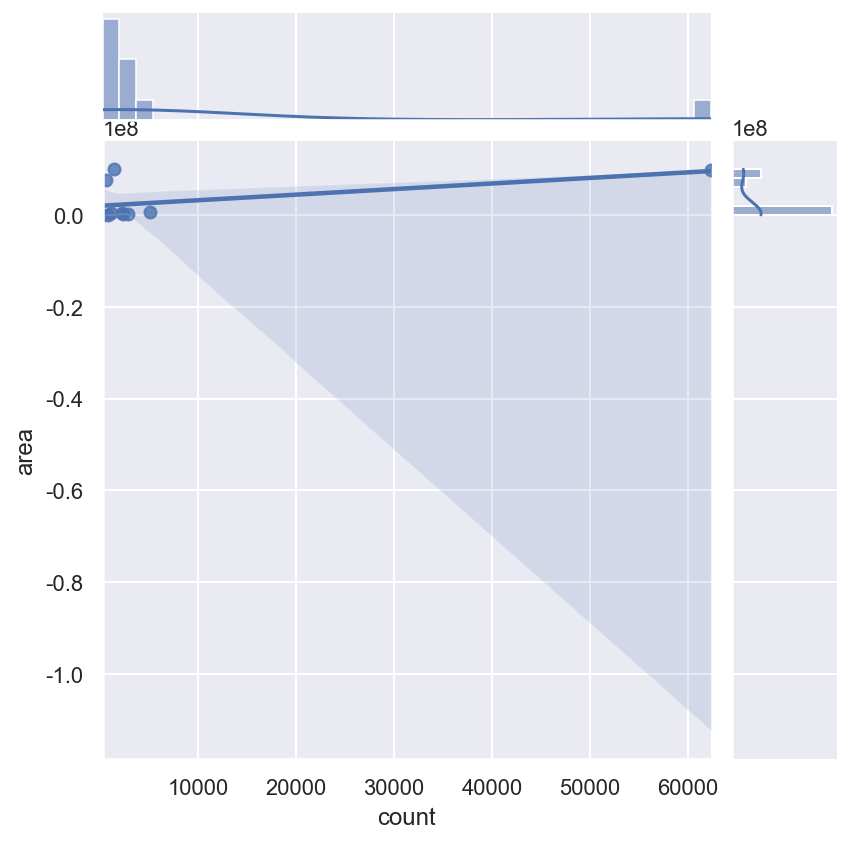

In [70]:
# 마지막으로 국가 규모가 예약 선호도와 관련이 있는지 여부를 확인
sns.jointplot(x='count', y='area', data=df_dp, kind='reg');

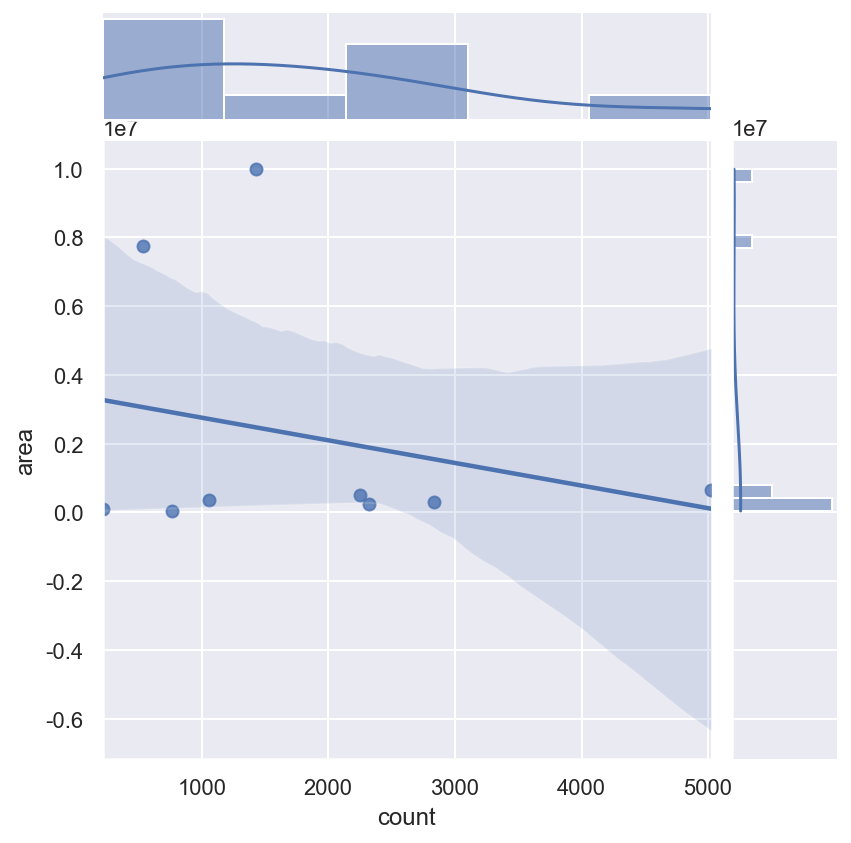

In [71]:
# 국가 규모와 예약 선호도와의 상관관계 (미국제외)
sns.jointplot(x='count', y='area', data=df_dp.drop('US'), kind='reg');

- 영역별 결과는 언어유사도에 대한 테스트에서 얻은 결과와 매우 유사함. 전반적으로 국가 규모와 예약 선호도 사이에는 긍정적인 상관관계가 있음, 이유는 미국이 큰 나라이기 때문에 크다.
- 그러나 미국이 제거되면 그 데이터는 부정적인 상관관계를 보여줌. 다시 말하지만 언어의 경우처럼, 예약선호도가 국가 크기와는 무관할 수 있지만 목적지 선호와는 관련이 없을 수 있다. 
- 유럽 국가들은 보통 크기는 작지만 미국 관광객들에게 매우 인기가 있다.

### 3-3 Seesion 
- 이번 파트에서는 제공된 세션 통계의 일부를 시각화하고자 함. 
- 먼저, 앞서 살펴본 것처럼 사용자가 각 세션에서 소비한 시간의 분포를 표시.

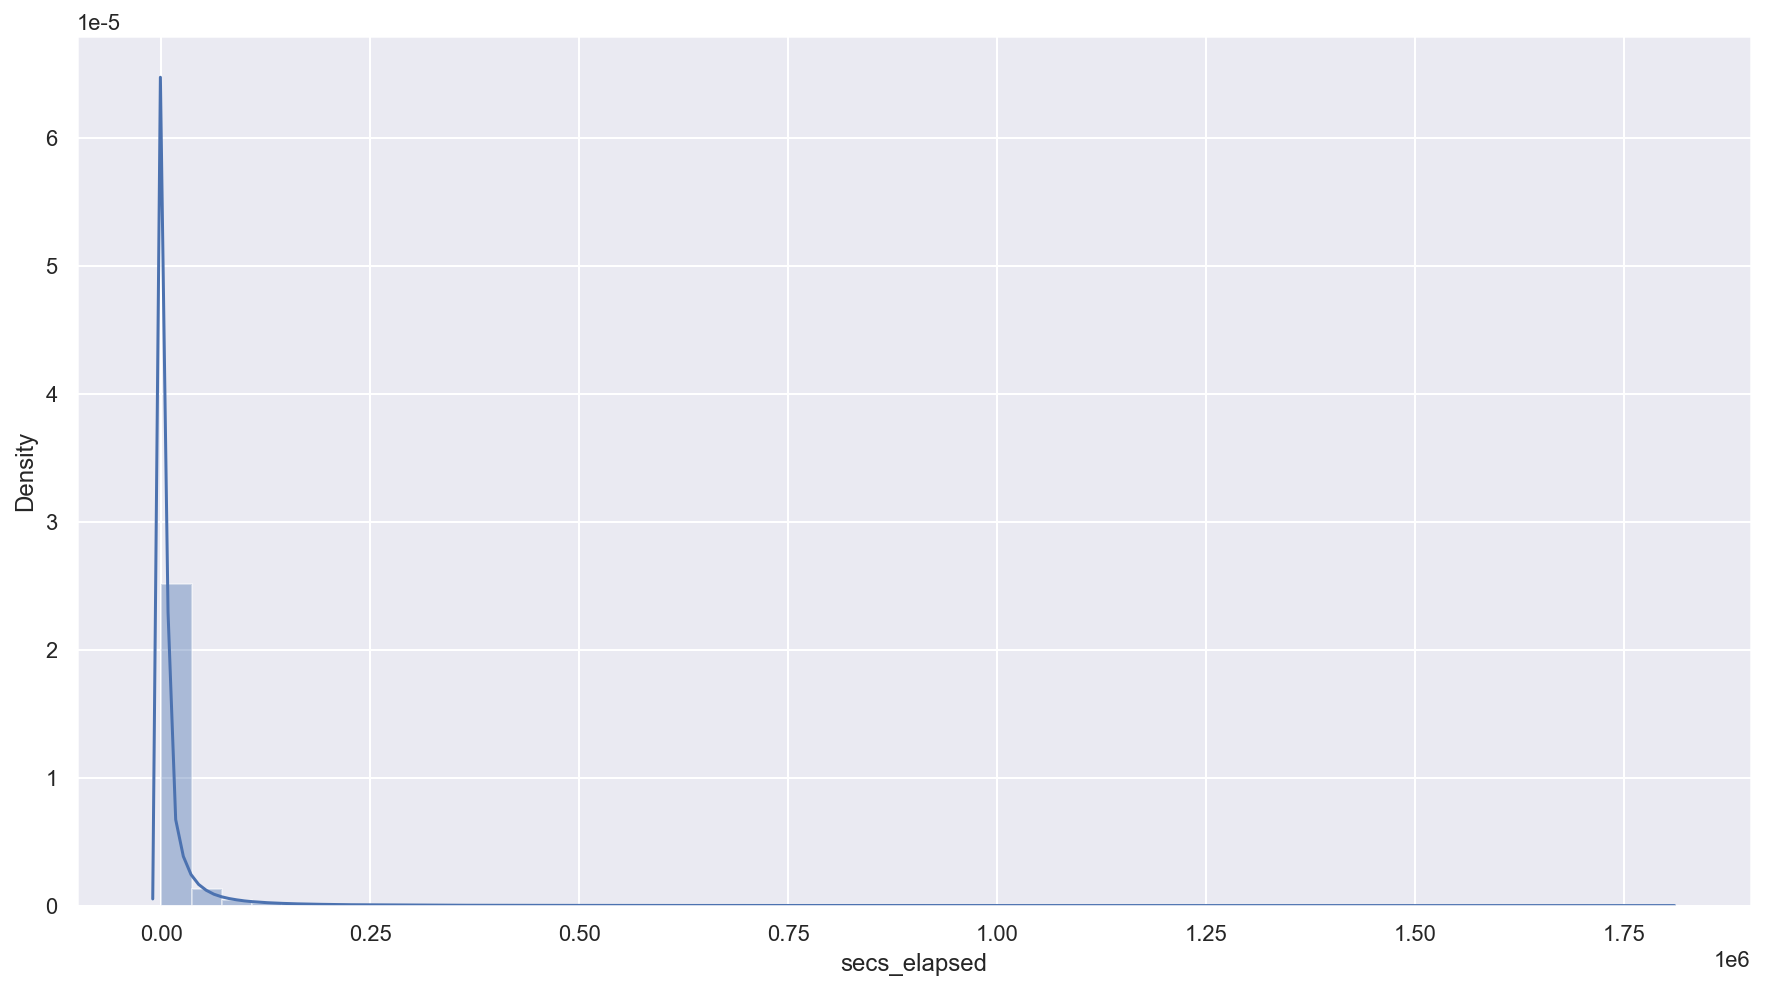

In [72]:
plt.figure(figsize=(15,8))
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed']);

- 거의 모든 세션의 길이는 5000초 미만으로 보임.

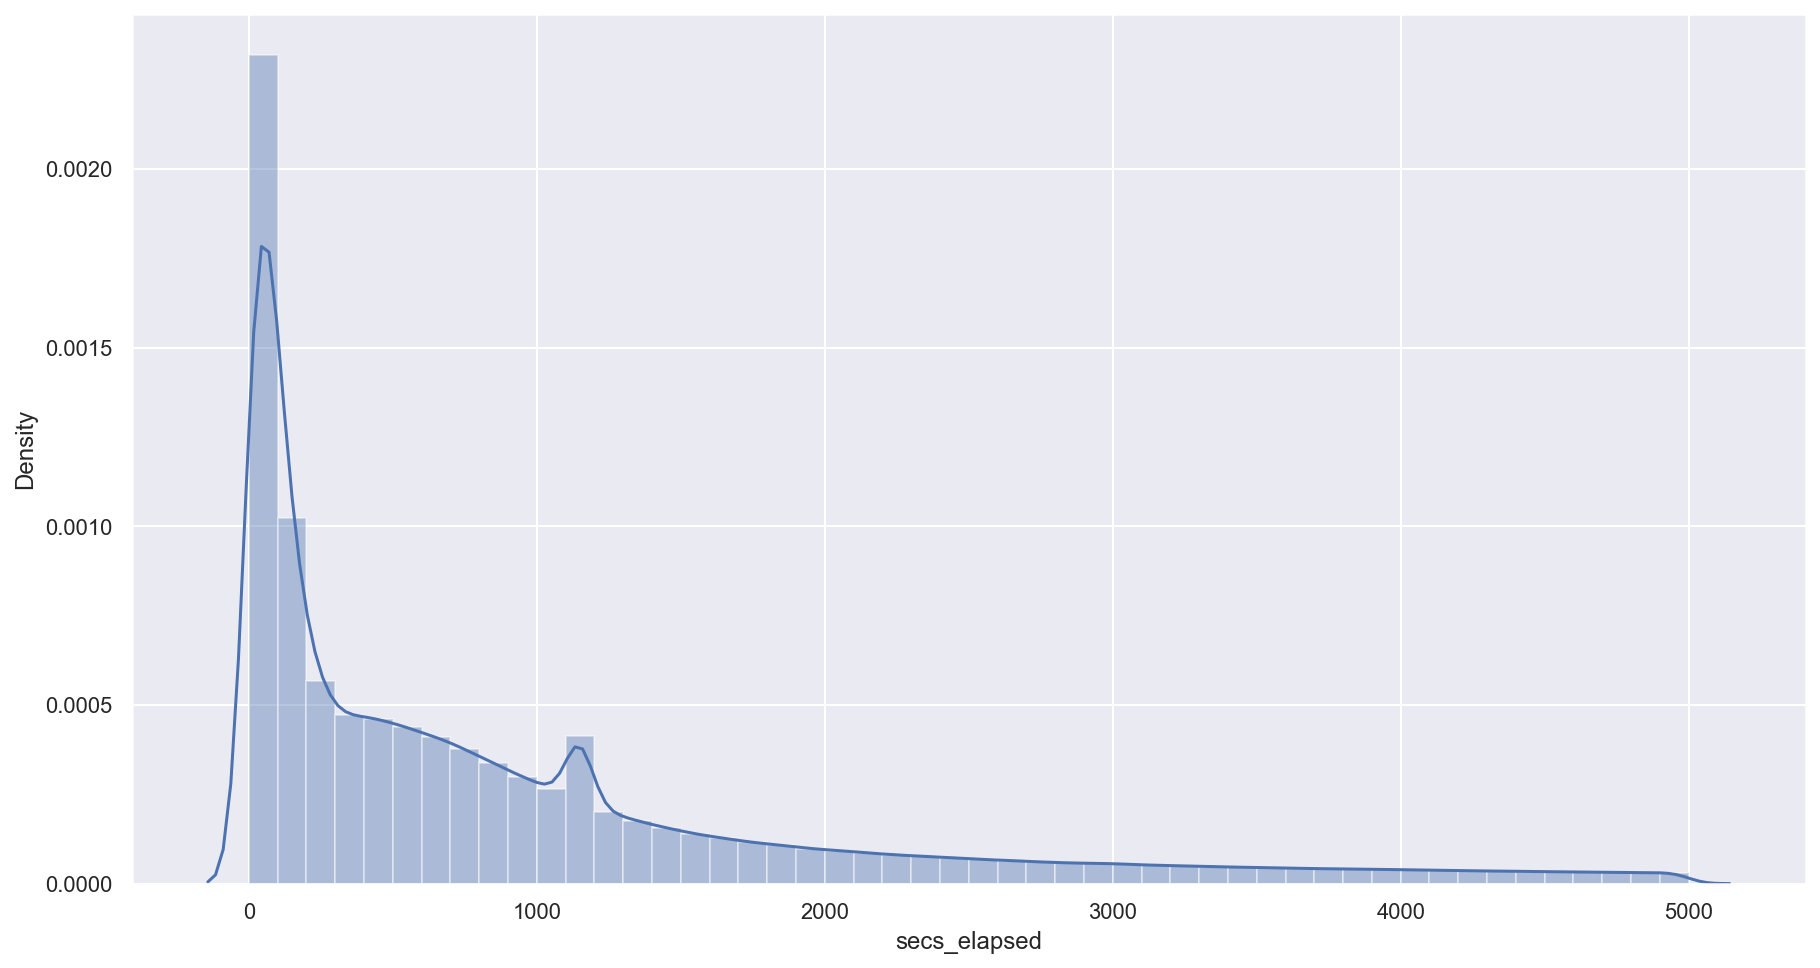

In [73]:
plt.figure(figsize=(15,8))
sns.distplot(df_ses[(df_ses['secs_elapsed'].notnull()) & (df_ses['secs_elapsed'] < 5000)]['secs_elapsed']);

- 1000초 이상의 세션 수가 거의 기하급수적으로 감소하는 것을 알 수 있음. 대부분의 유저 활동시간은 1000초 미만이었다고 가정하는 것이 옳아보임.

In [74]:
# 교차 점검하기 위해 전체 세션 수에서 차지하는 비율을 살펴보기 (4937921(유저활동시간 1000초 미만의 데이터 수) / 10567737(유저활동시간 결측치를 뺀 데이터 수))
len(df_ses[df_ses['secs_elapsed'] < 1000]) / len(df_ses[df_ses['secs_elapsed'].notnull()])

0.4672638049186879

- 전체 세션의 거의 47%가 1000초 미만이었음. 이는 1000초를 초과한 세션에서 유저활동시간의 분포가 감소하는 것을 강력히 시사함. 
- 다시 말해, 초 수가 증가하면 그만큼 활동수가 기하급수적으로 줄어듬을 의미.

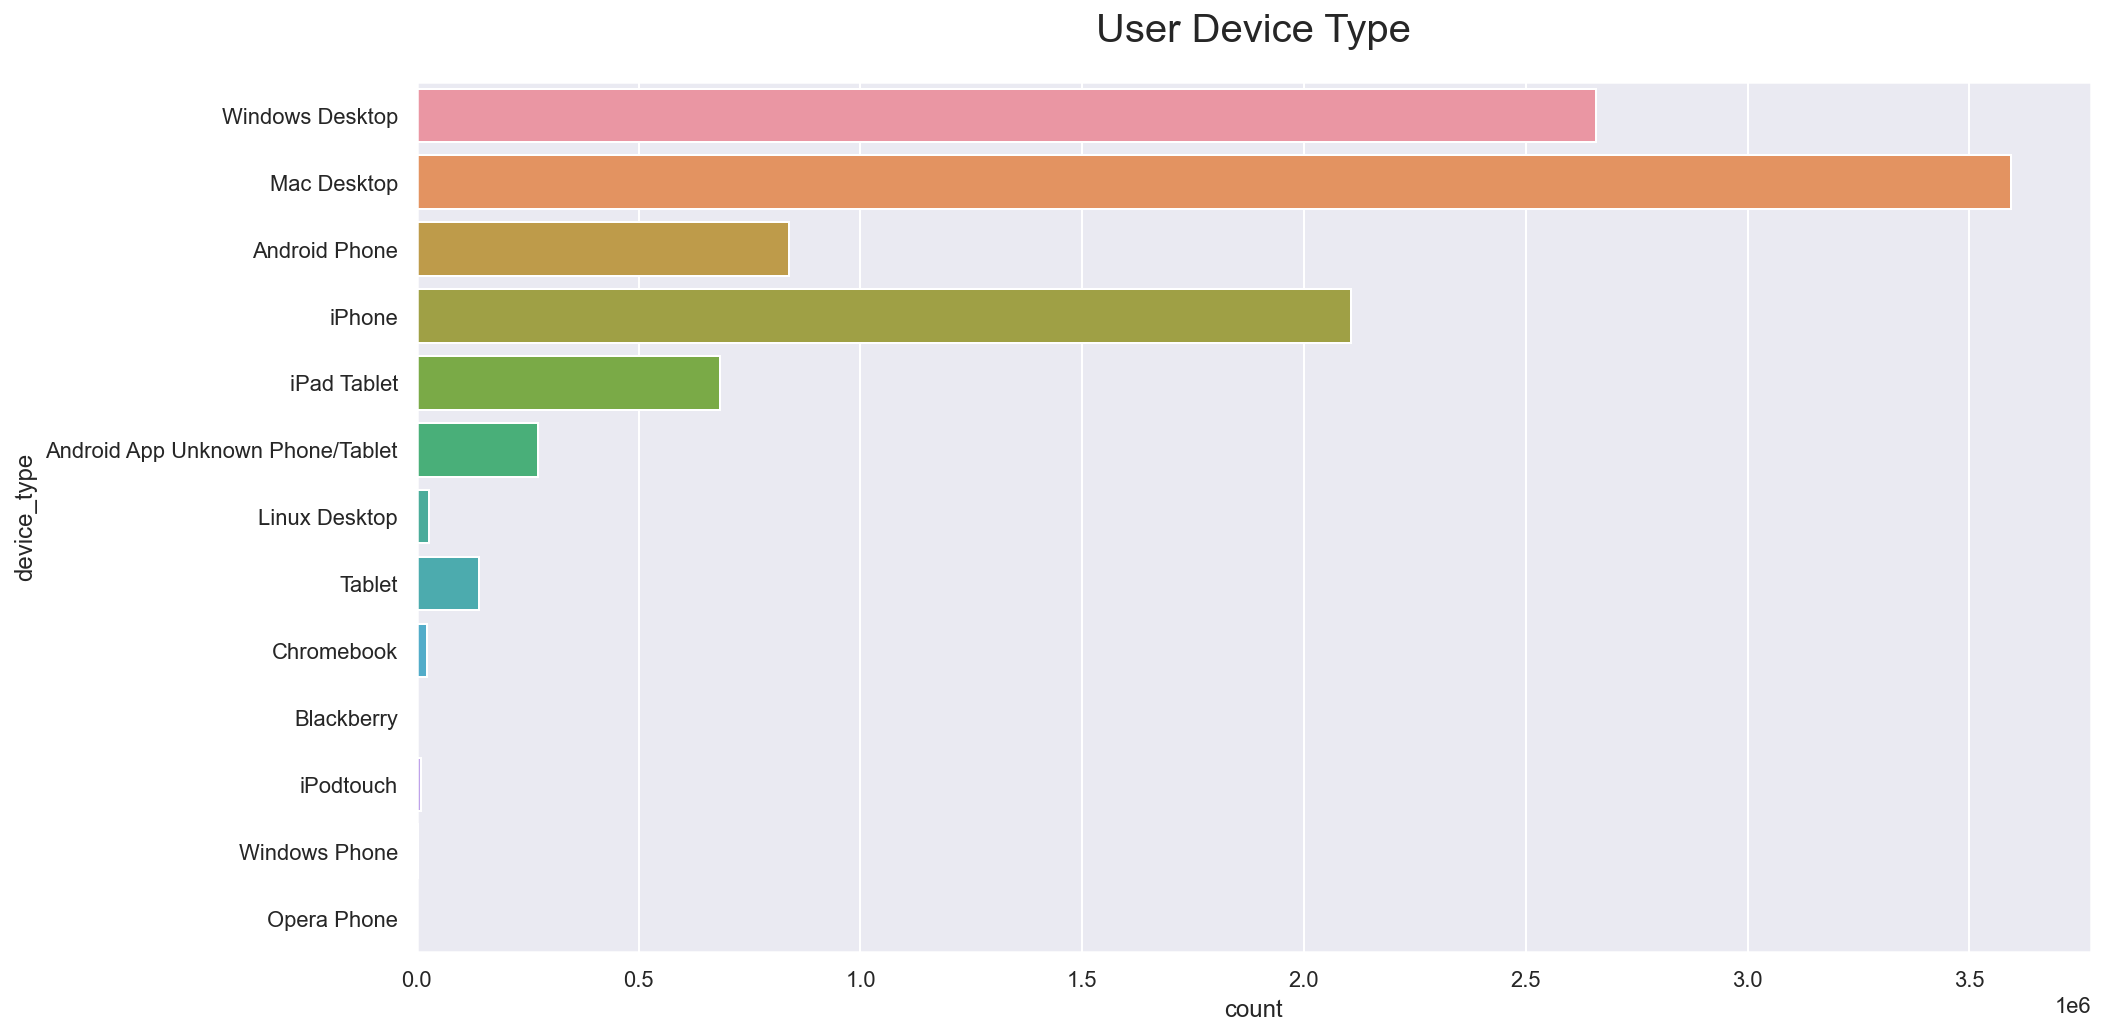

In [75]:
# Airbnb 웹사이트와 App에서 사용자가 사용하는 모든 기기의 막대그래프를 구성
plt.figure(figsize=(15,8))
plt.title("User Device Type", fontsize=20, pad=20)
sns.countplot(y='device_type', data=df_ses);

- Mac Desktop은 Airbnb 사용자들 사이에서 가장 인기 있는 기기이며, 그 다음이 Windows Desktop이다.
- 흥미로운 점은 유저 대부분이 애플 제품을 많이 사용한다는 점이다.

### 3-4 Train Dataset User 분석 
- 주요 데이터셋인 Train 데이터셋에 대한 통찰력을 얻는 것이 목적 
- 이러한 통찰력은 Feature Engineering 및 Machine Learning의 이후 단계에 직접 적용할 수 있음.

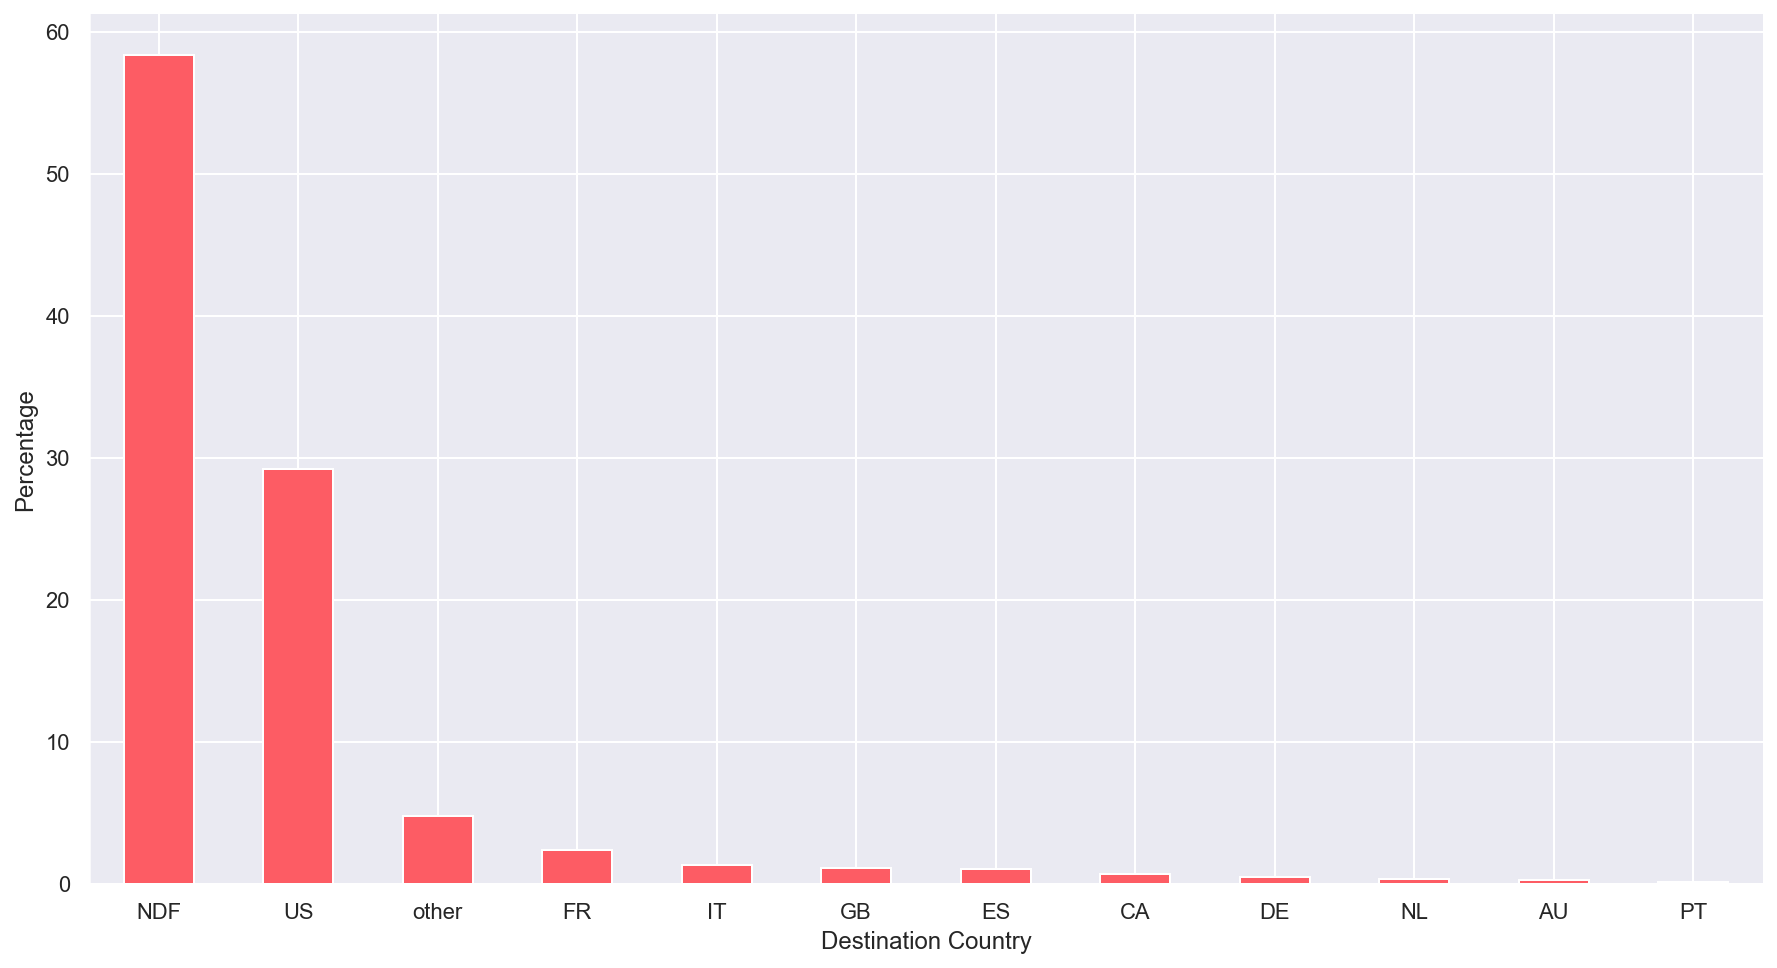

In [76]:
# 우선 train 데이터 목적지 국가 분포율 그래프 
plt.figure(figsize=(15, 8))
country_share = df_train['country_destination'].value_counts() / df_train.shape[0] * 100
country_share.plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

- 60%에 가까운 사용자들이 에어비앤비를 예약한 적이 없음. 기존 사용자들 중, 압도적으로 미국을 첫 번째 목적지로 선택함. 
- 기계 학습 모델을 train할 때 예약자와 비예약자를 구분하는 것이 중요할 것으로 보임.
- 이후 예약자 분류는 우리가 클래스 불균형을 유리하게 이용할 수 있어 매우 정확할 것으로 보인다.

In [77]:
classes = ['NDF', 'US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT']

In [78]:
# 누적 막대 그래프를 그리기 위한 함수 (pd.crosstab:데이터 재구조화)
def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], 
                       df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(title=feature, figsize=(12,8), kind='bar', stacked=True, colormap='terrain', legend=False)
    plt.show()

#### 1) 성별

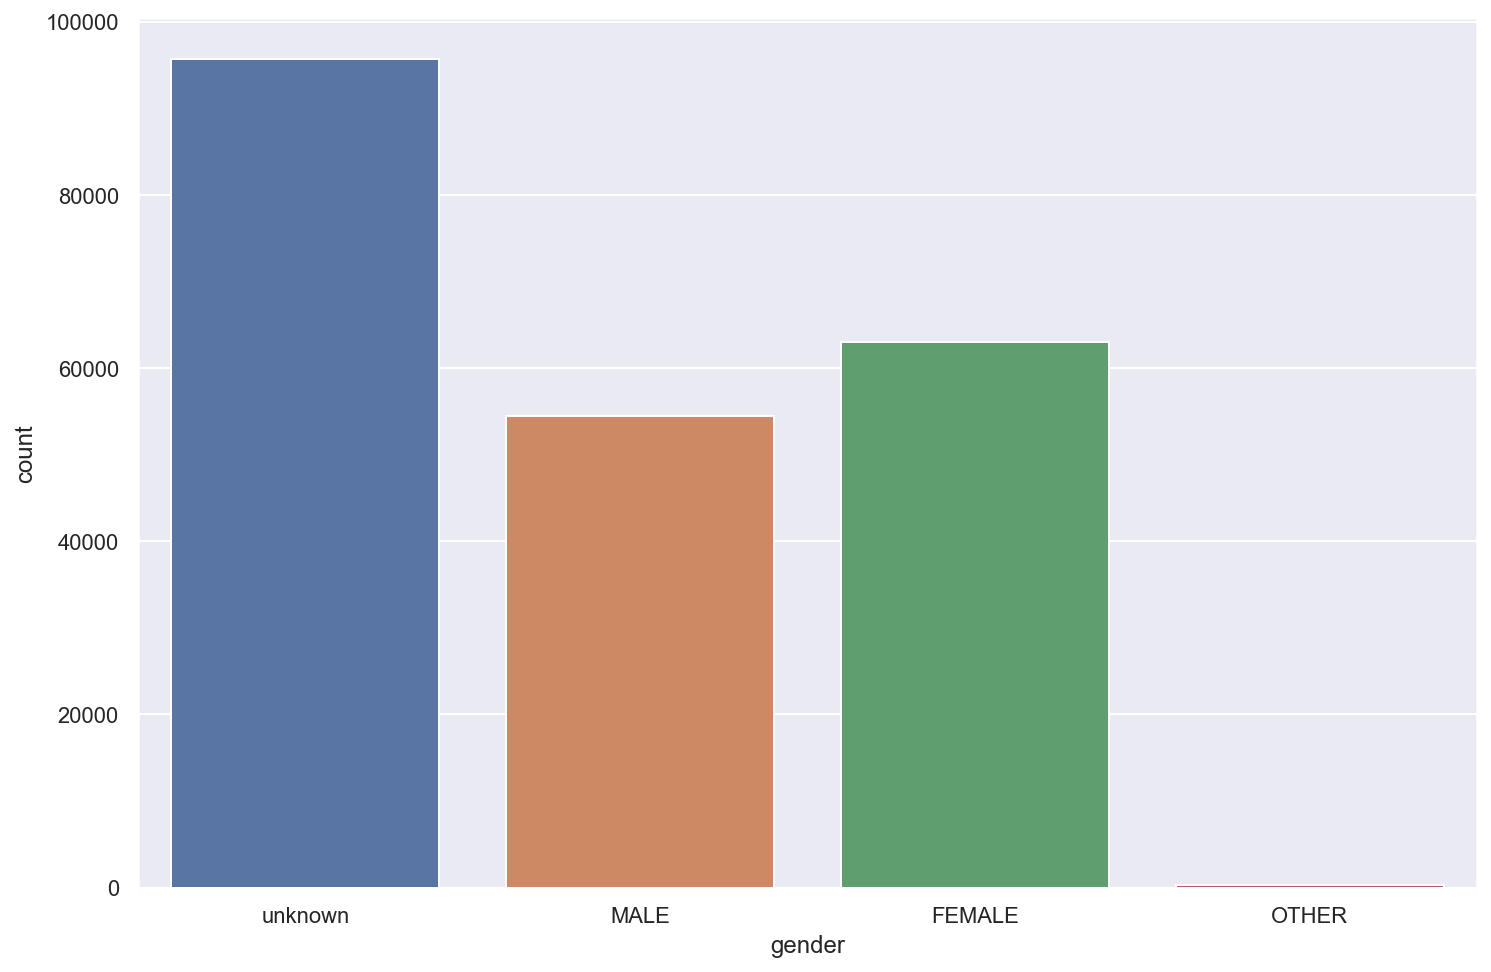

In [79]:
plt.figure(figsize=(12,8))
sns.countplot(df_train['gender'].fillna('unknown'));

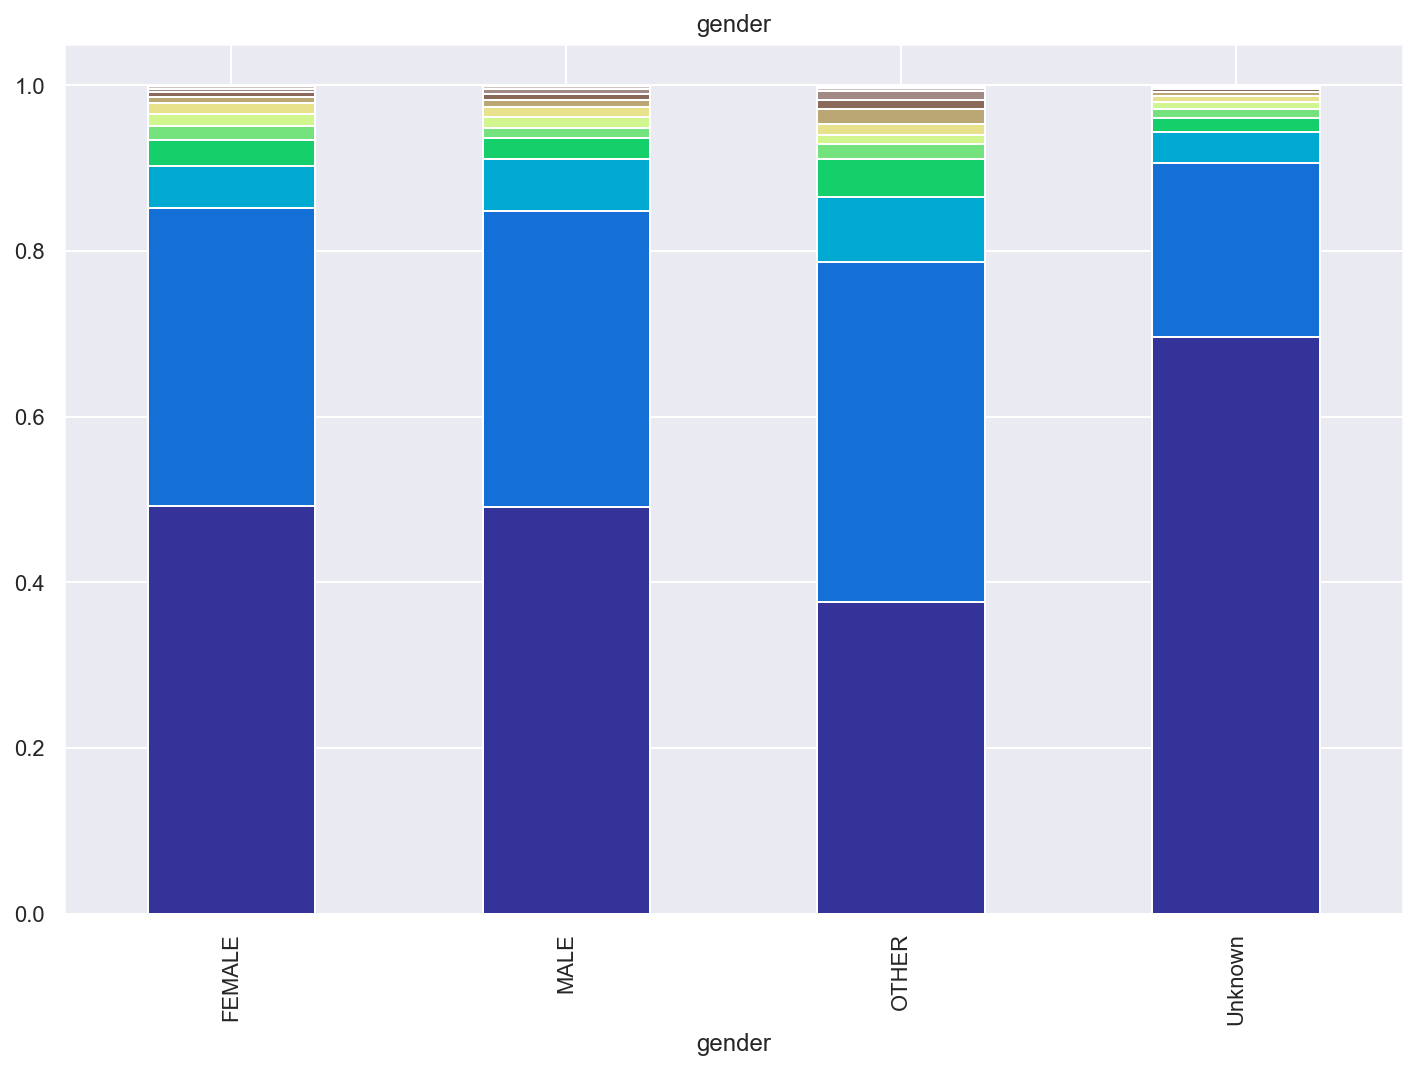

In [80]:
# 함수로 만든 누적 막대그래프로 표현
stacked_bar('gender')

- 누적 막대형 차트는 각 색상이 클래스(또는 대상)을 나타냄. 관련된 색상은 **NDF**는 **'진한 파란색'**과 **US 클래스**는 **'파란색'**(색상이 진할수록 막대 위치가 맨 밑에 있음)
- 우리가 추론해 볼 것은 예약을 한번도 진행해본적이 없는 집단(진한 파란색)
    - 해당 그래프를 본 결과, **성별을 알 수 없는 사용자(Unknown)** 집단이 대다수임을 알 수있음. 성별이 명확히 표시된 사용자에서는 여성이 남성보다 많음. 해당 그래프로 2가지를 알 수 있음.
        - 1. 에어비앤비 사용량 중 남성 이용자 보다 **여성 이용자가 더 많다.**
        - 2. 성별이 명확히 표시된 사용자 비율은 남성보다 **여성이 더 많다.**
    - 한 가지 흥미로운 점은 **성별을 알 수 없는 사용자(Unknown)** 집단이 에어비앤비를 덜 예약한다는 것이다. 또한, 성별을 **'기타(other)'**라고 표시한 사람들은 다른 어떤 그룹보다 예약을 할 가능성이 높아보인다.

#### 2) 연령대

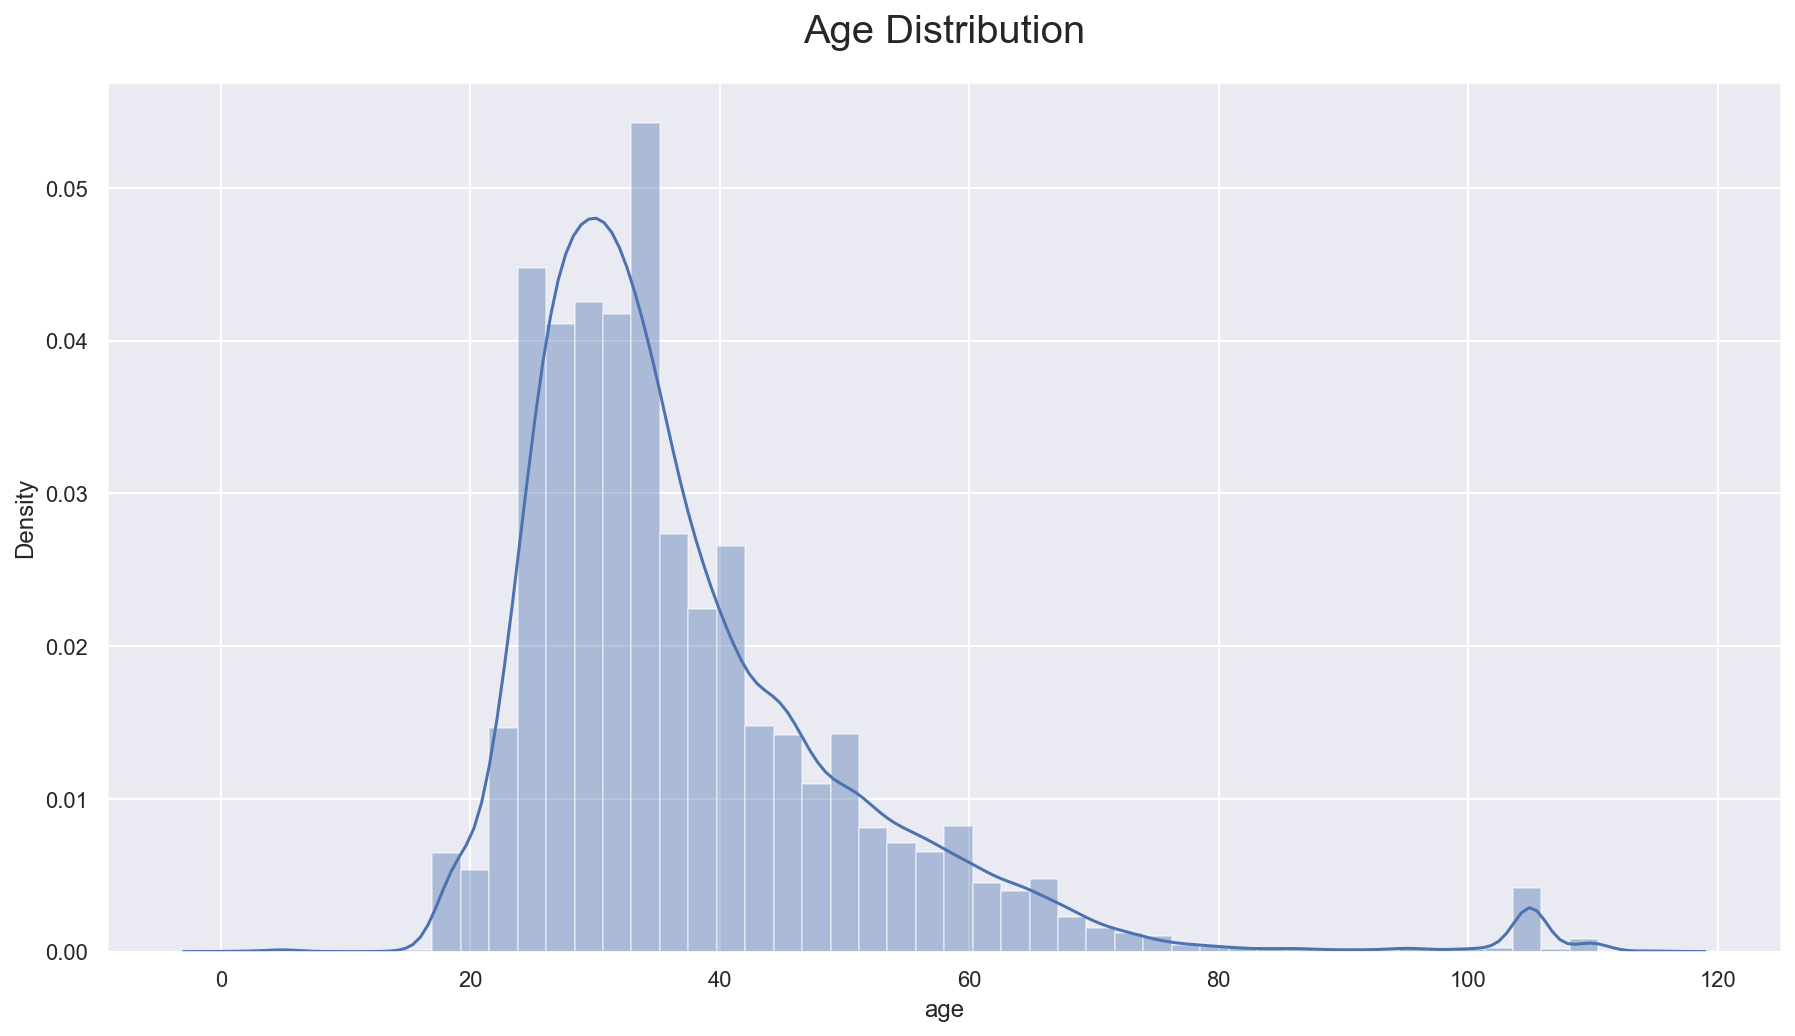

In [81]:
# 연령대 분포 히스토그램
plt.figure(figsize=(15,8))
plt.title("Age Distribution", fontsize=20, pad=20)
sns.distplot(df_train['age'].dropna());

-일부 연령층 즉 30대 ~ 40대의 분포가 높다. 그렇다면 일부 연령층이 특정 목적지에 예약할 가능성이 높을까?

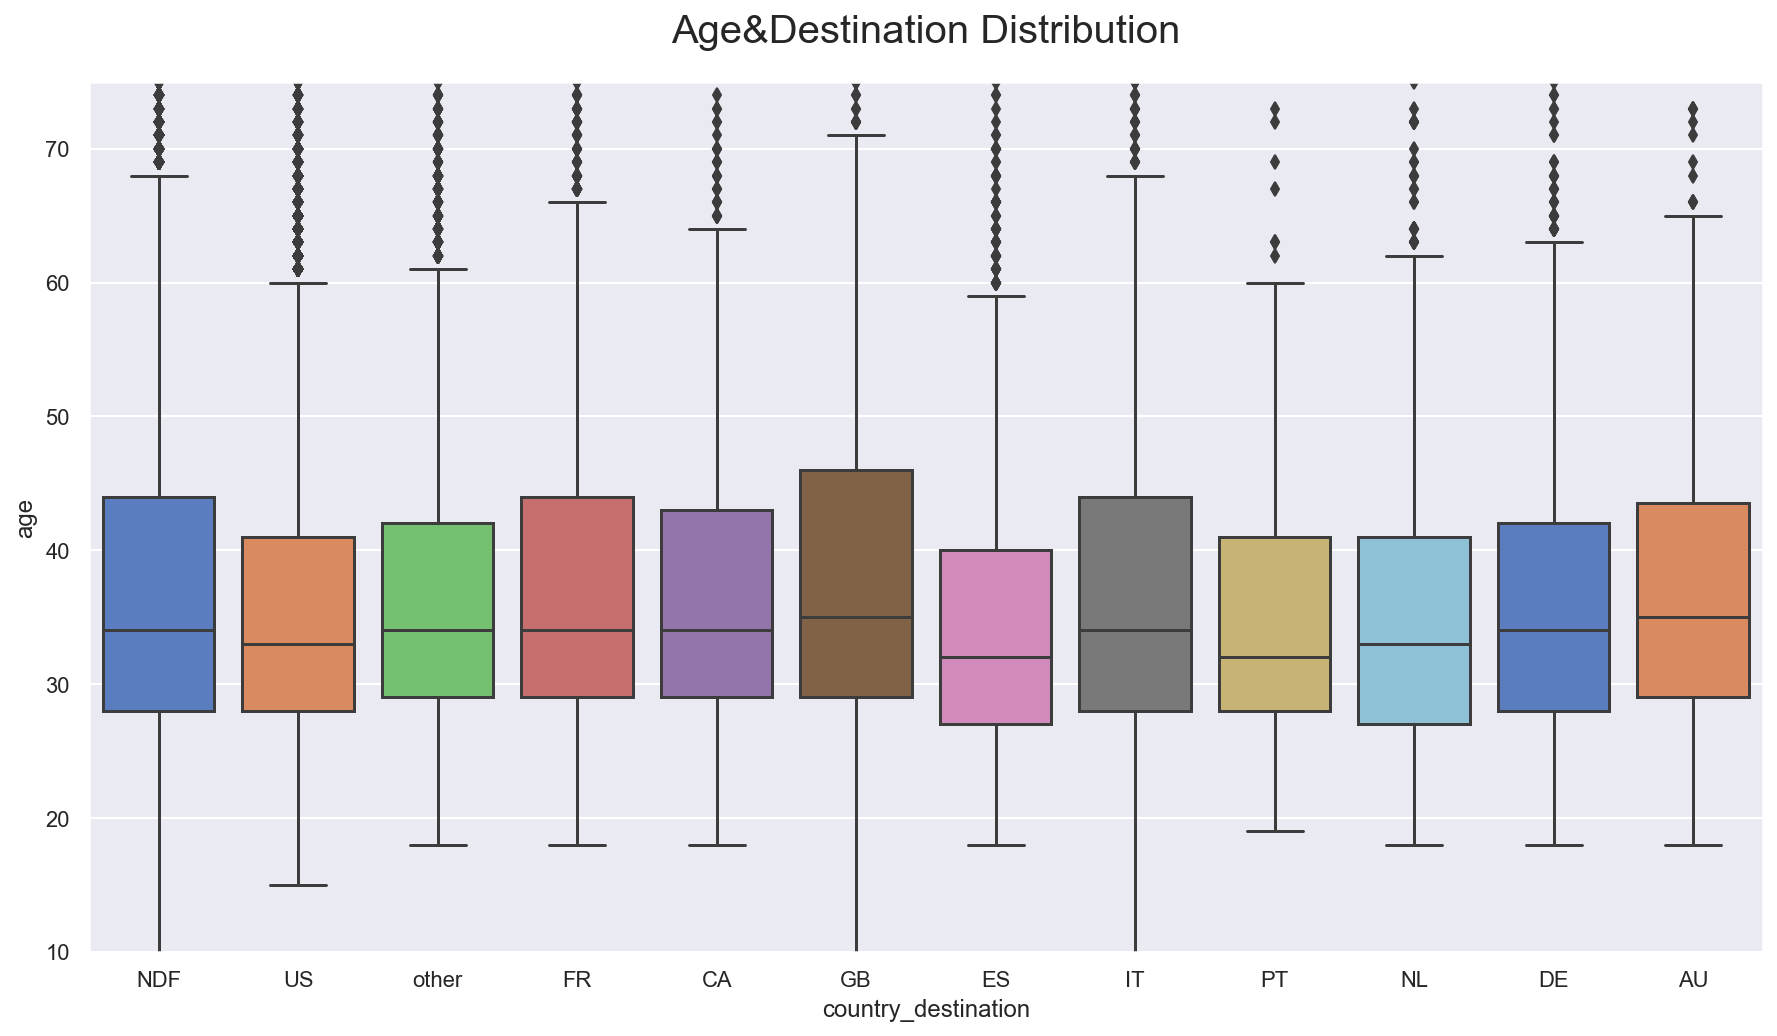

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax=ax)
plt.title('Age&Destination Distribution', fontsize=20, pad=20)
ax.set_ylim([10, 75]);

- 구성된 박스플롯을 통해 모든 국가에 대해 다소 동일한 분포가 있음을 알 수 있음. 영국은 여행자의 중위연령이 가장 높고 스페인은 젊은 여행자들에게 더 인기가 있는 것으로 보인다. 

In [83]:
# 연령대 그룹을 나누는 함수 
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >= 40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

In [84]:
# 연령대 그룹을 추가
df_train['age_group'] = df_train['age'].apply(set_age_group)

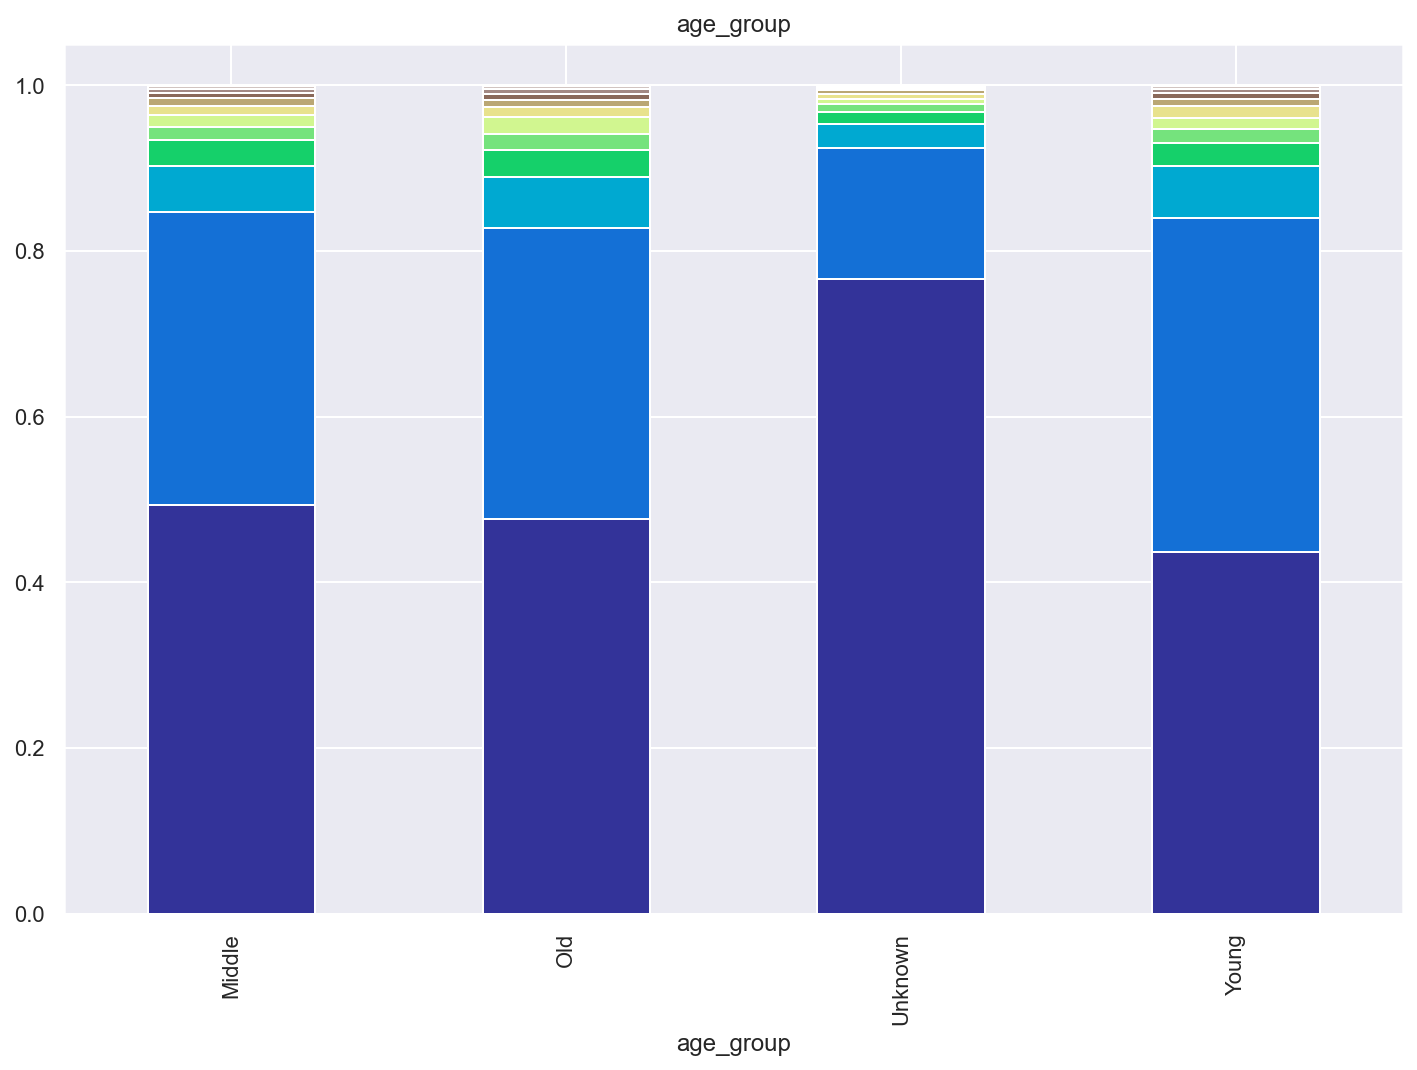

In [85]:
stacked_bar('age_group')

- 이용자를 4가지 연령을 그룹화 시킴
    - 40세 미만의 사람들은 **청년층**.
    - 40세에서 60세 사이의 사람들은 **중년층**.
    - 60세 이상의 사람들은 **노년층**.
    - 나이를 알 수 없는 사람들은 **알 수 없는 사람**으로 분류.
- 연련대도 마찬가지, **나이를 밝히지 않은 사람들**이 에어비앤비를 예약할 가능성이 낮음을 발견. 
- **중장년층**이 에어비앤비를 예약할 가능성이 높음.

#### 3) 가입방법
- 이전 **'가입환경설정 파트'**에서에서 **에어비앤비** 및 **Facebook**이 가장 선호하는 가입 방법이라는 것을 이미 확인함. 
- 구글은 거의 사용되지 않았음.

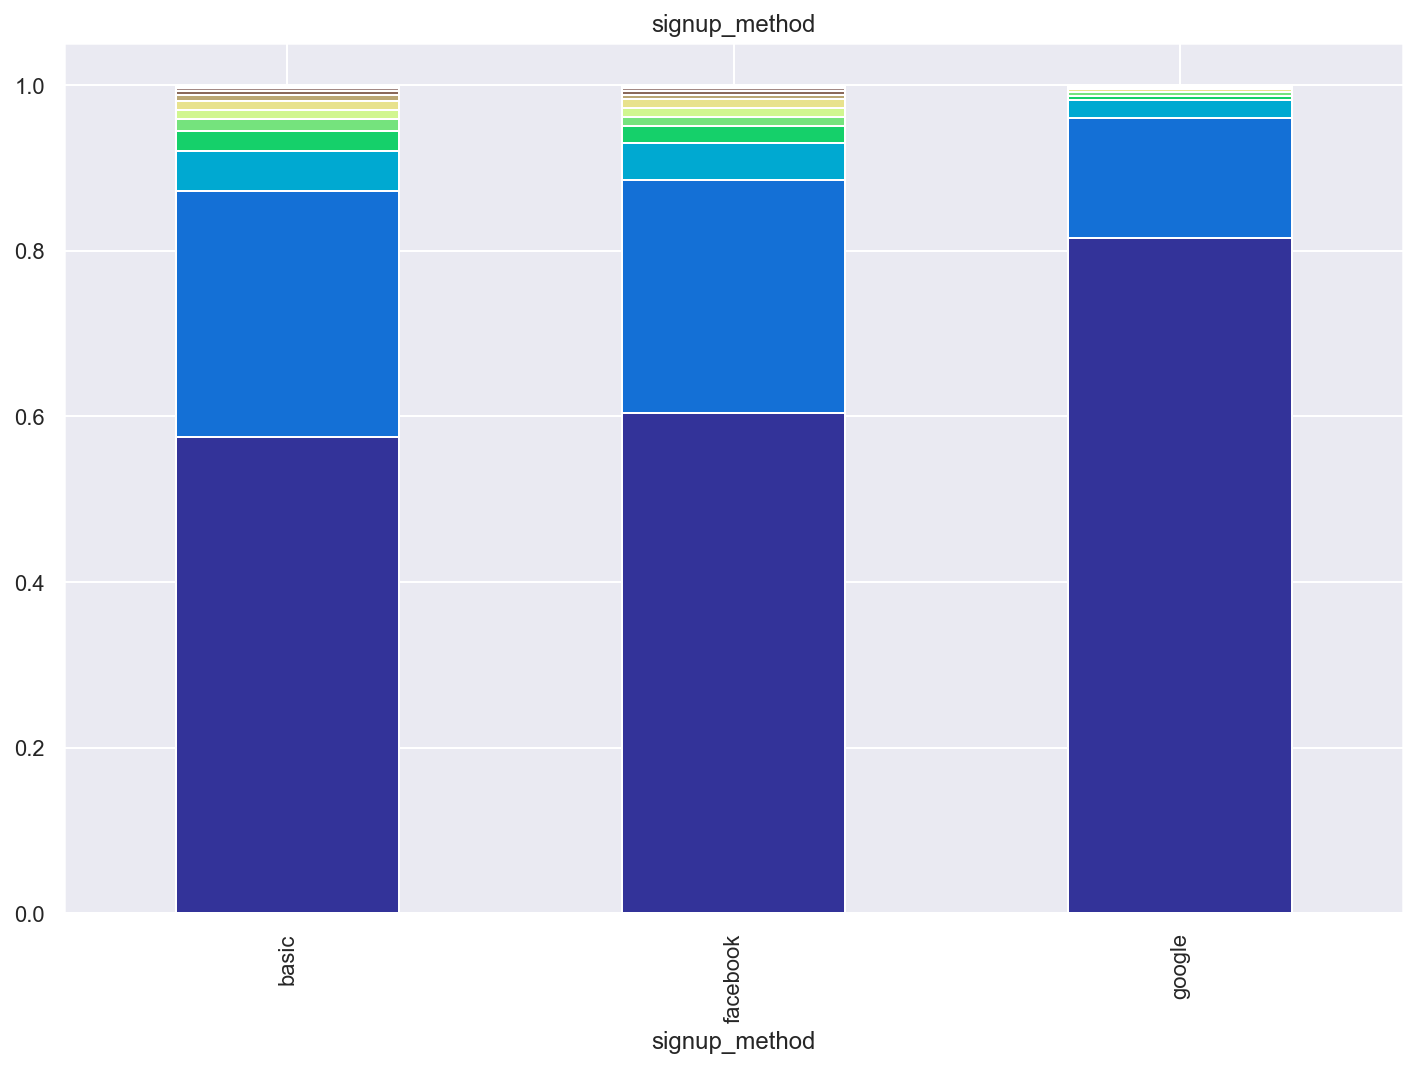

In [86]:
stacked_bar('signup_method')

- **기본(에어비앤비)**경로로 통한 회원가입 방식을 사용하는 사람들은 에어비앤비로 예약할 가능성이 가장 높은 반면, **구글**를 통해 사용하는 사람들은 예약이 가장 낮은 것으로 나타났다.

#### 4) 언어

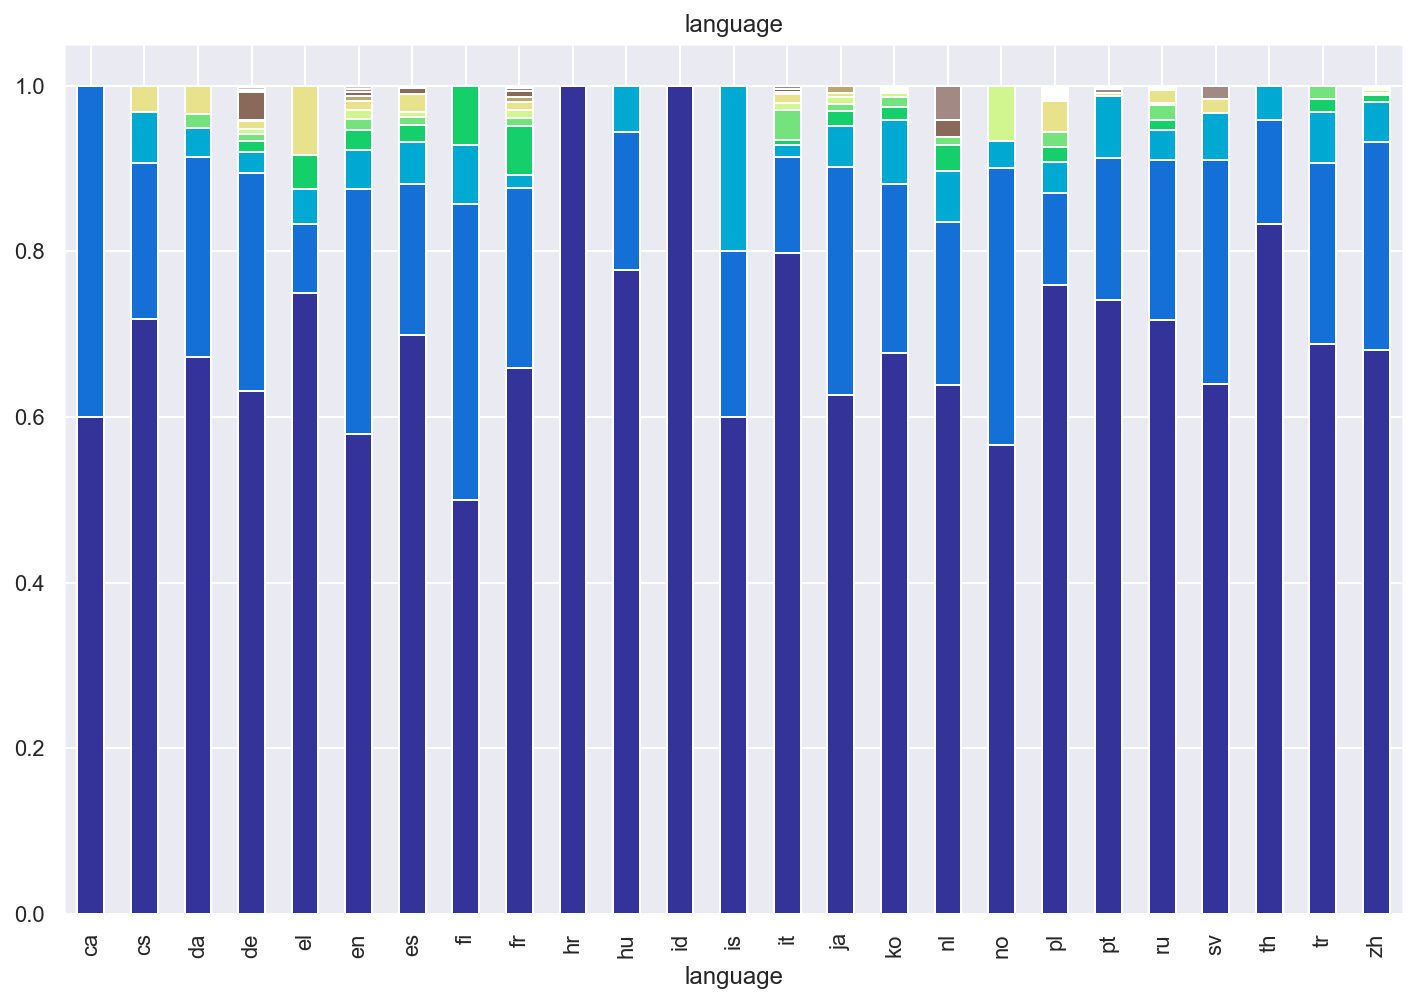

In [87]:
stacked_bar('language')

- 헝가리와 인도네시아어를 사용하는 사람들은 거의 예약을 하지 않았음.
- 핀란드어를 사용하는 사람들이 모든 언어 중에서 가장 많은 예약을 했음. 
- 그러나 사용자 대부분이 미국인이기 때문에 영어 이외의 사용자는 소수라고 가정해도 무방함.

#### 5) 제휴체널 및 가입제공자

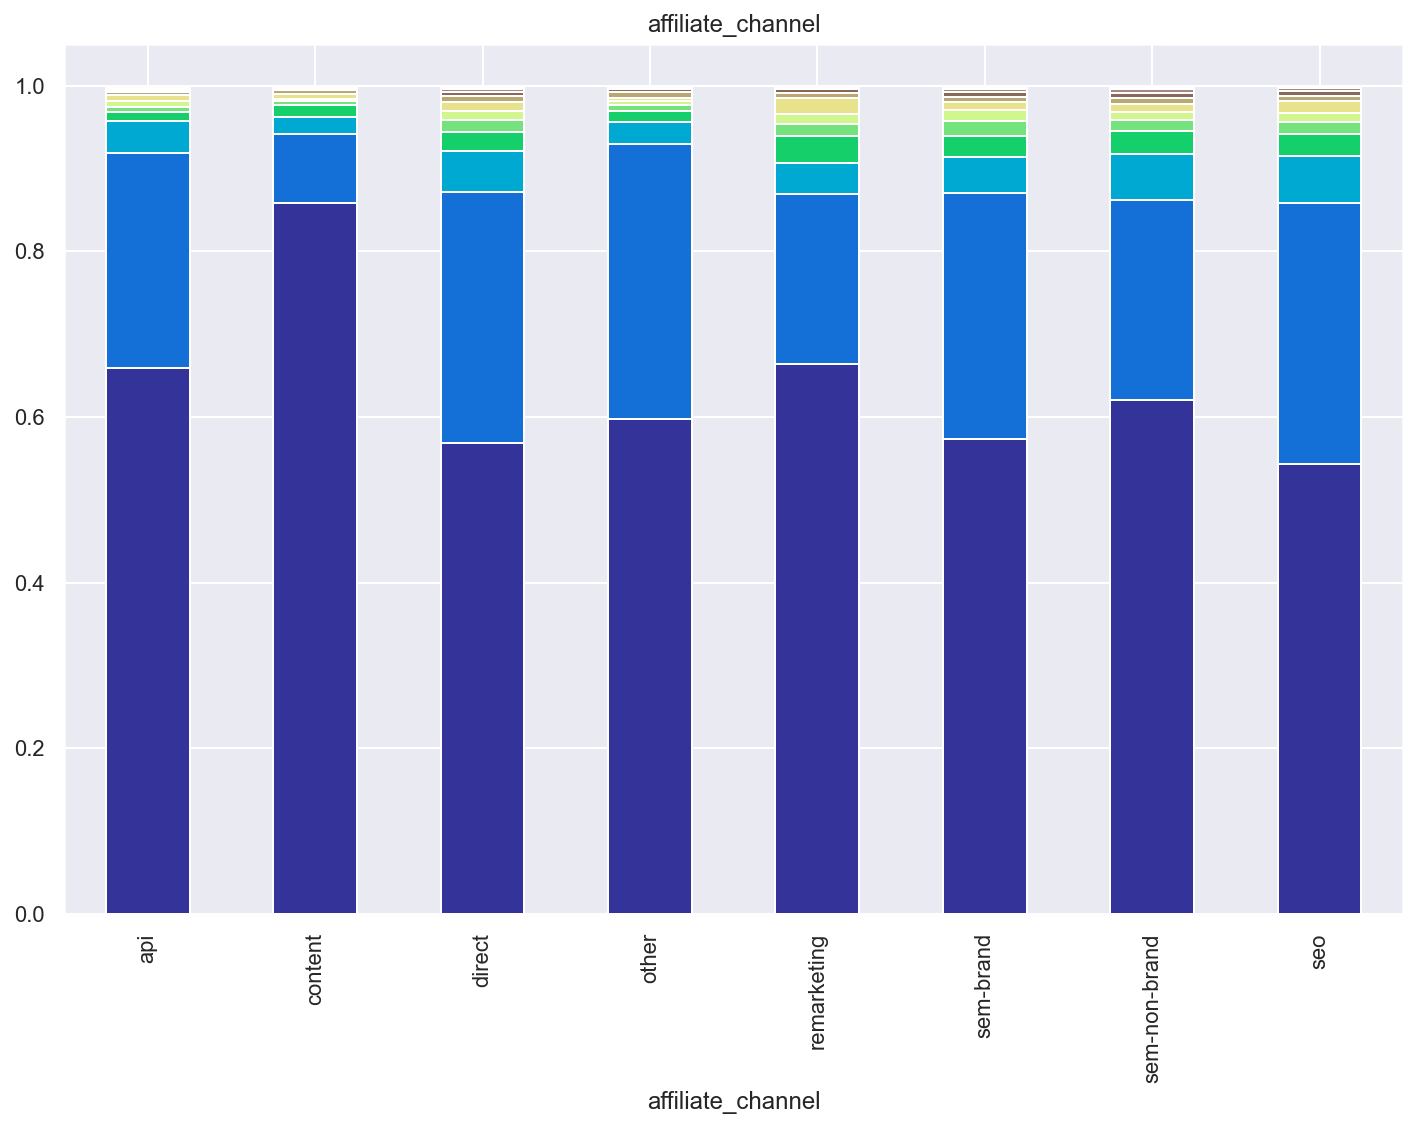

In [88]:
# 제휴체널 그래프
stacked_bar('affiliate_channel')

- 목적지 국가로 구분 짓지 않은, 일반 barplot으로 그려, 같이 비교 해보겠음.

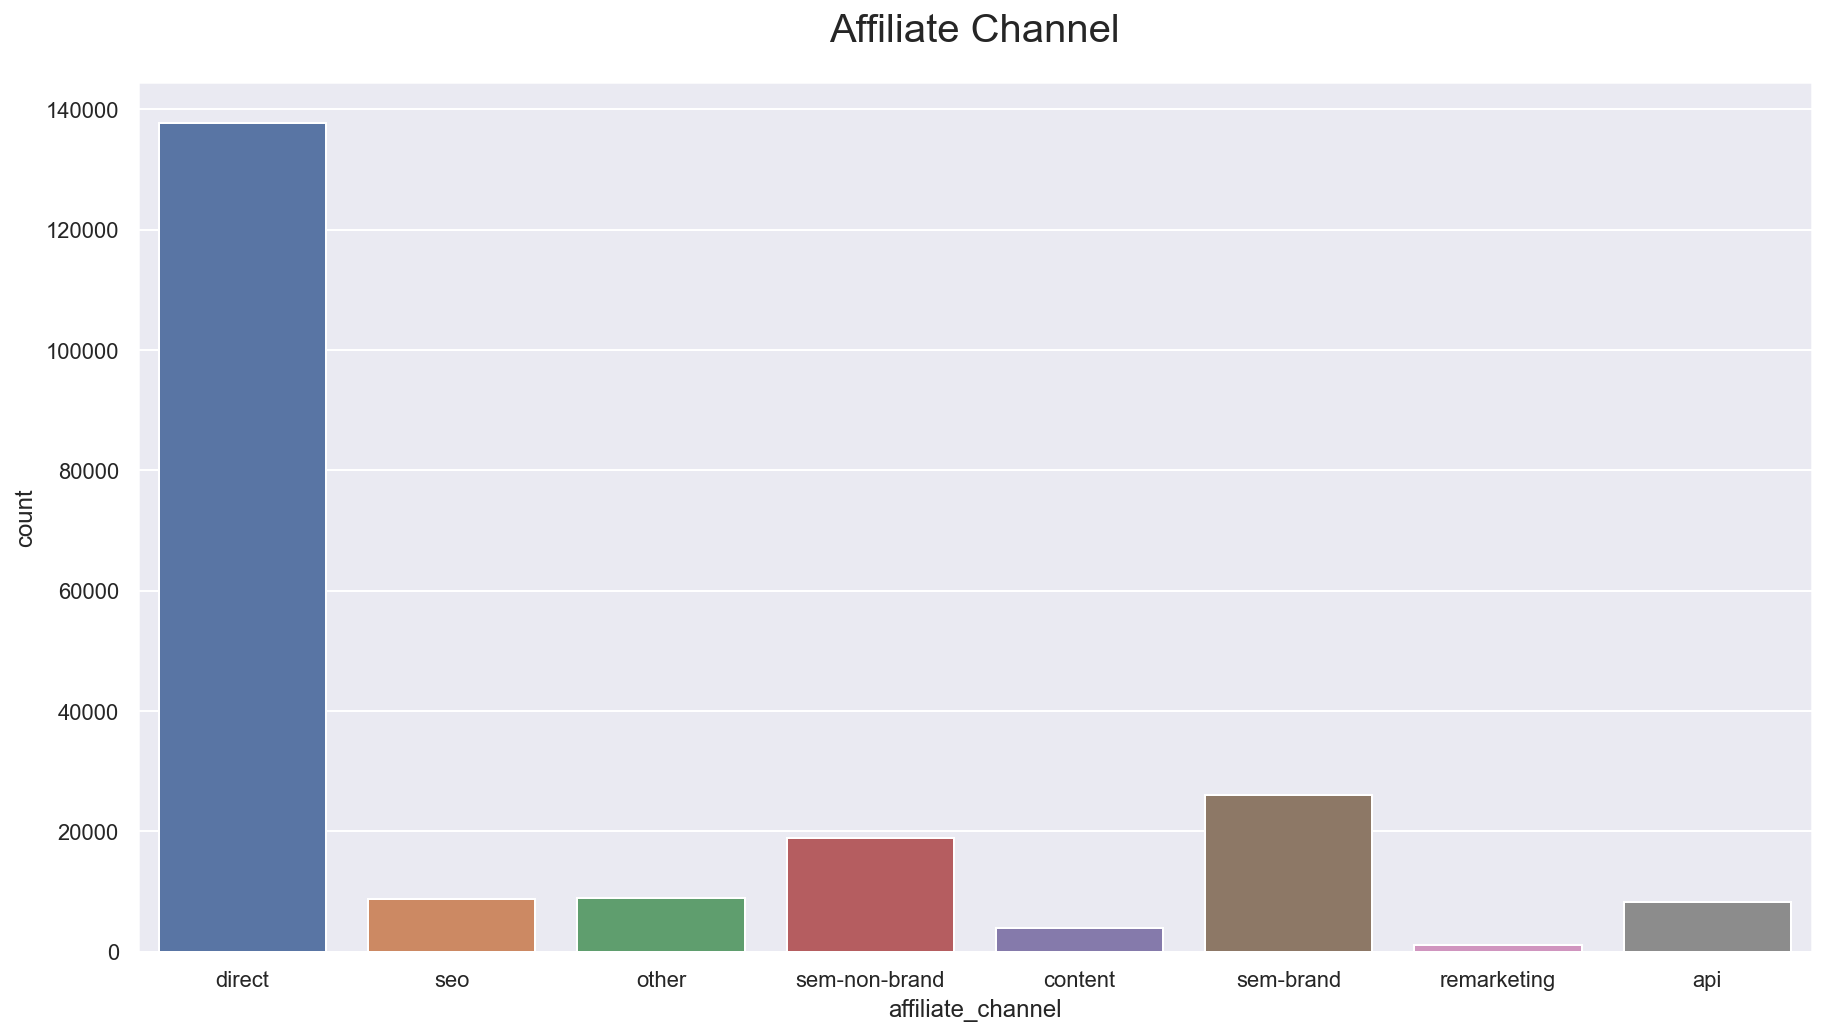

In [89]:
# barplot으로 그래기
plt.figure(figsize=(15,8))
sns.countplot(df_train['affiliate_channel'])
plt.title("Affiliate Channel", fontsize=20, pad=20)
plt.show()

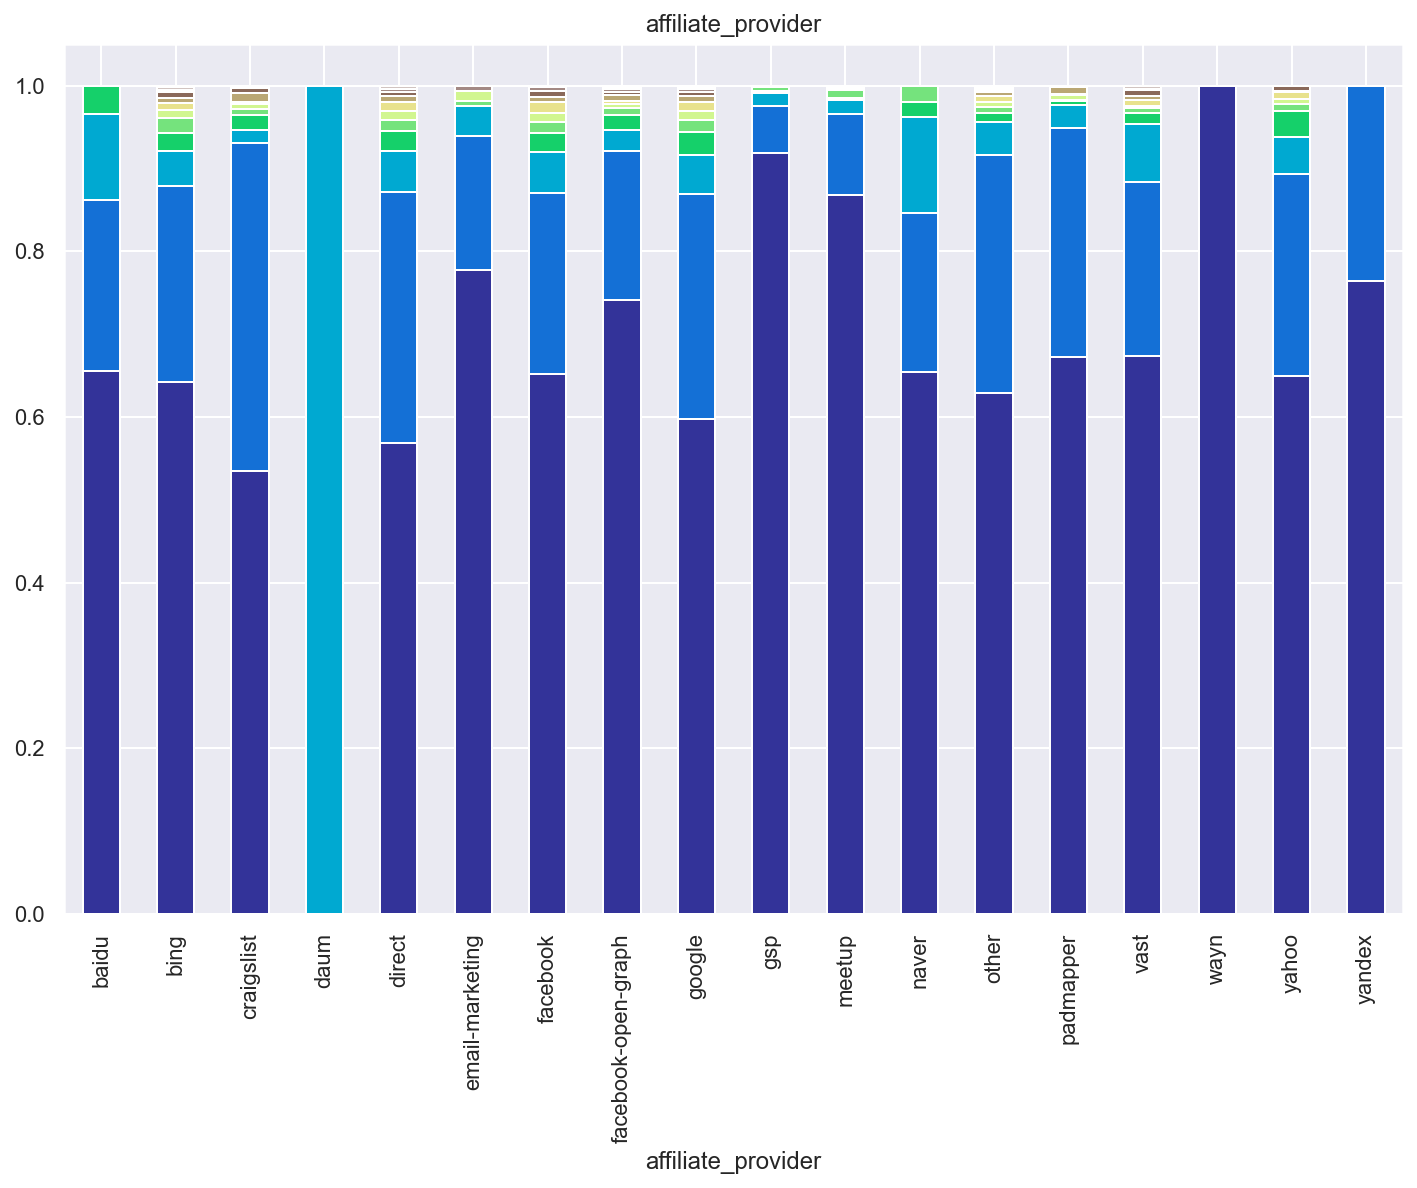

In [90]:
# 가입제공자 그래프 
stacked_bar('affiliate_provider')

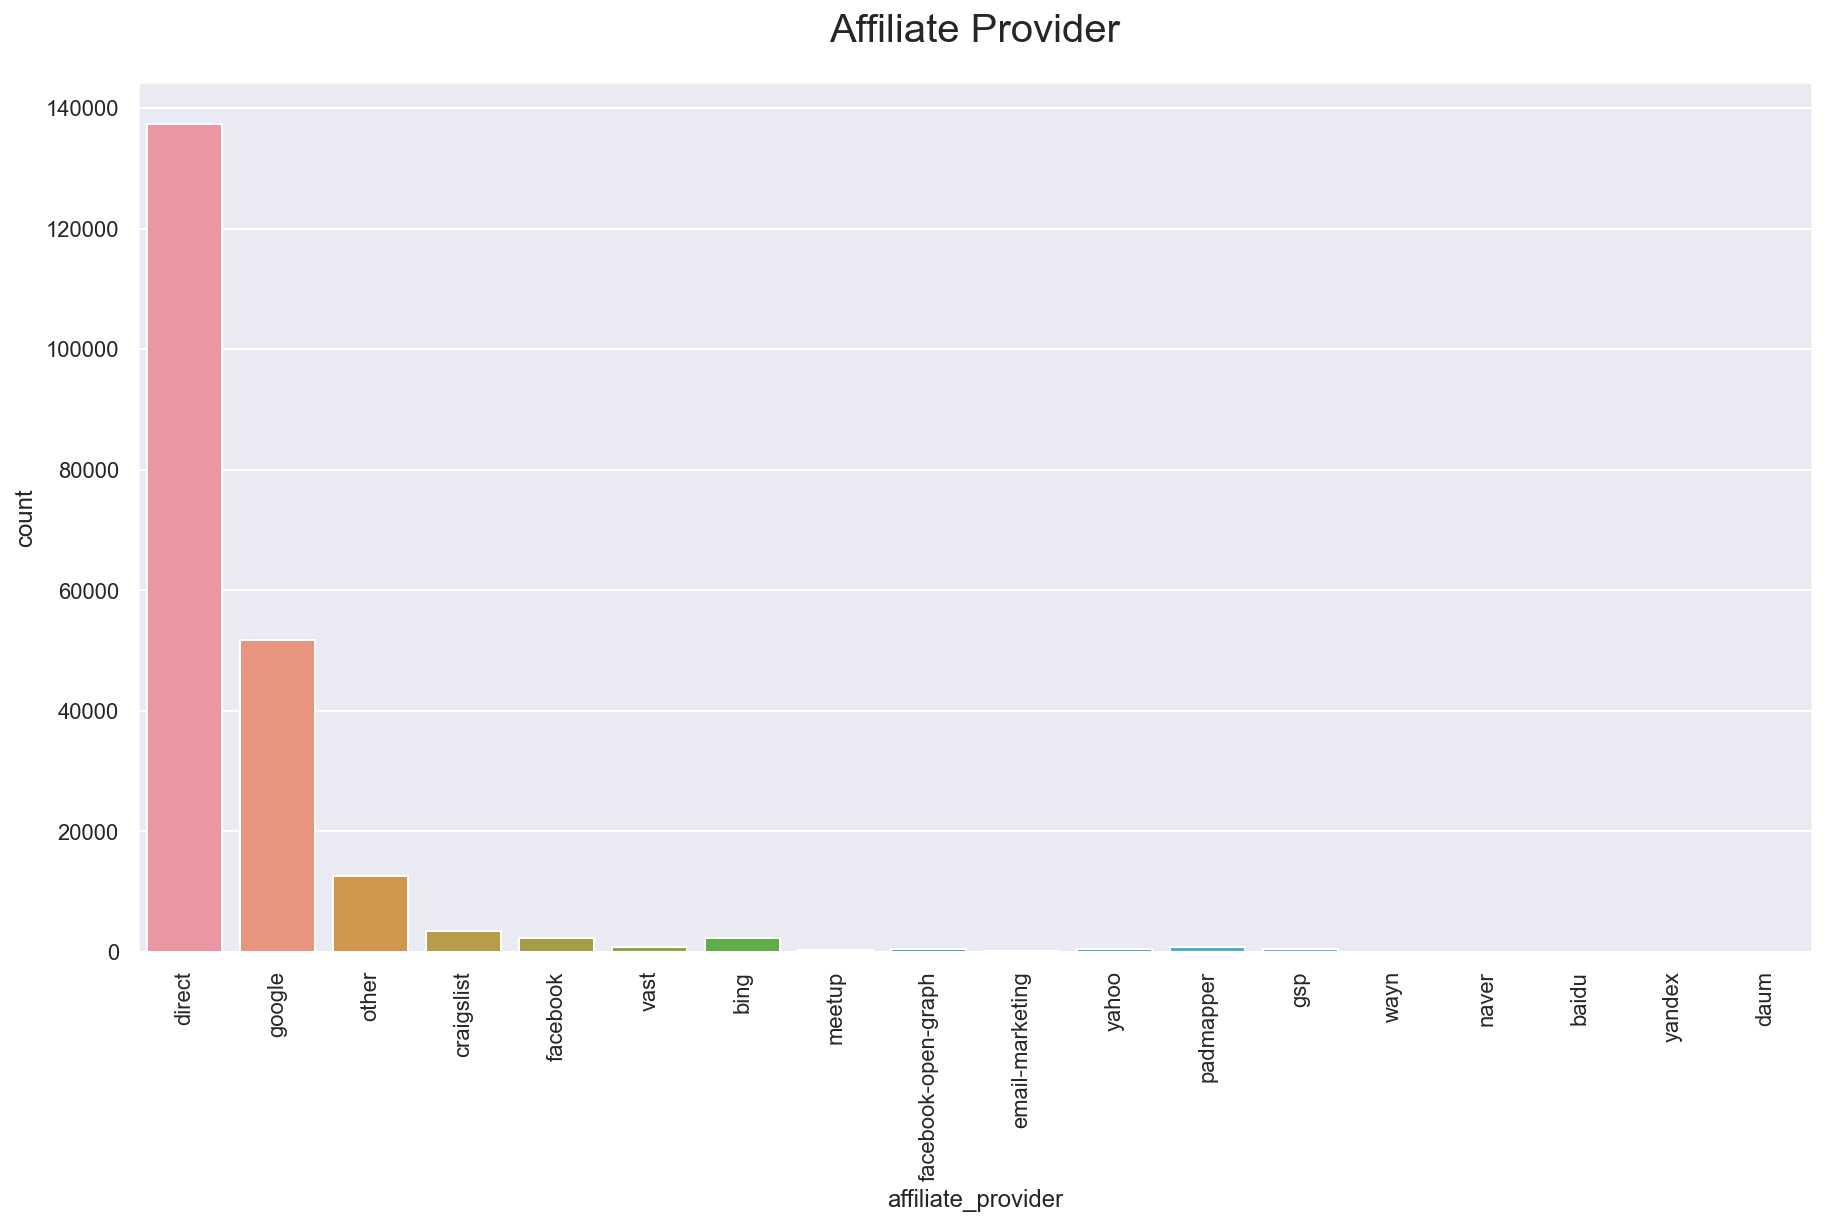

In [91]:
plt.figure(figsize=(15,8))
sns.countplot(df_train['affiliate_provider'])
plt.title("Affiliate Provider", fontsize=20, pad=20)
plt.xticks(rotation=90)
plt.show()

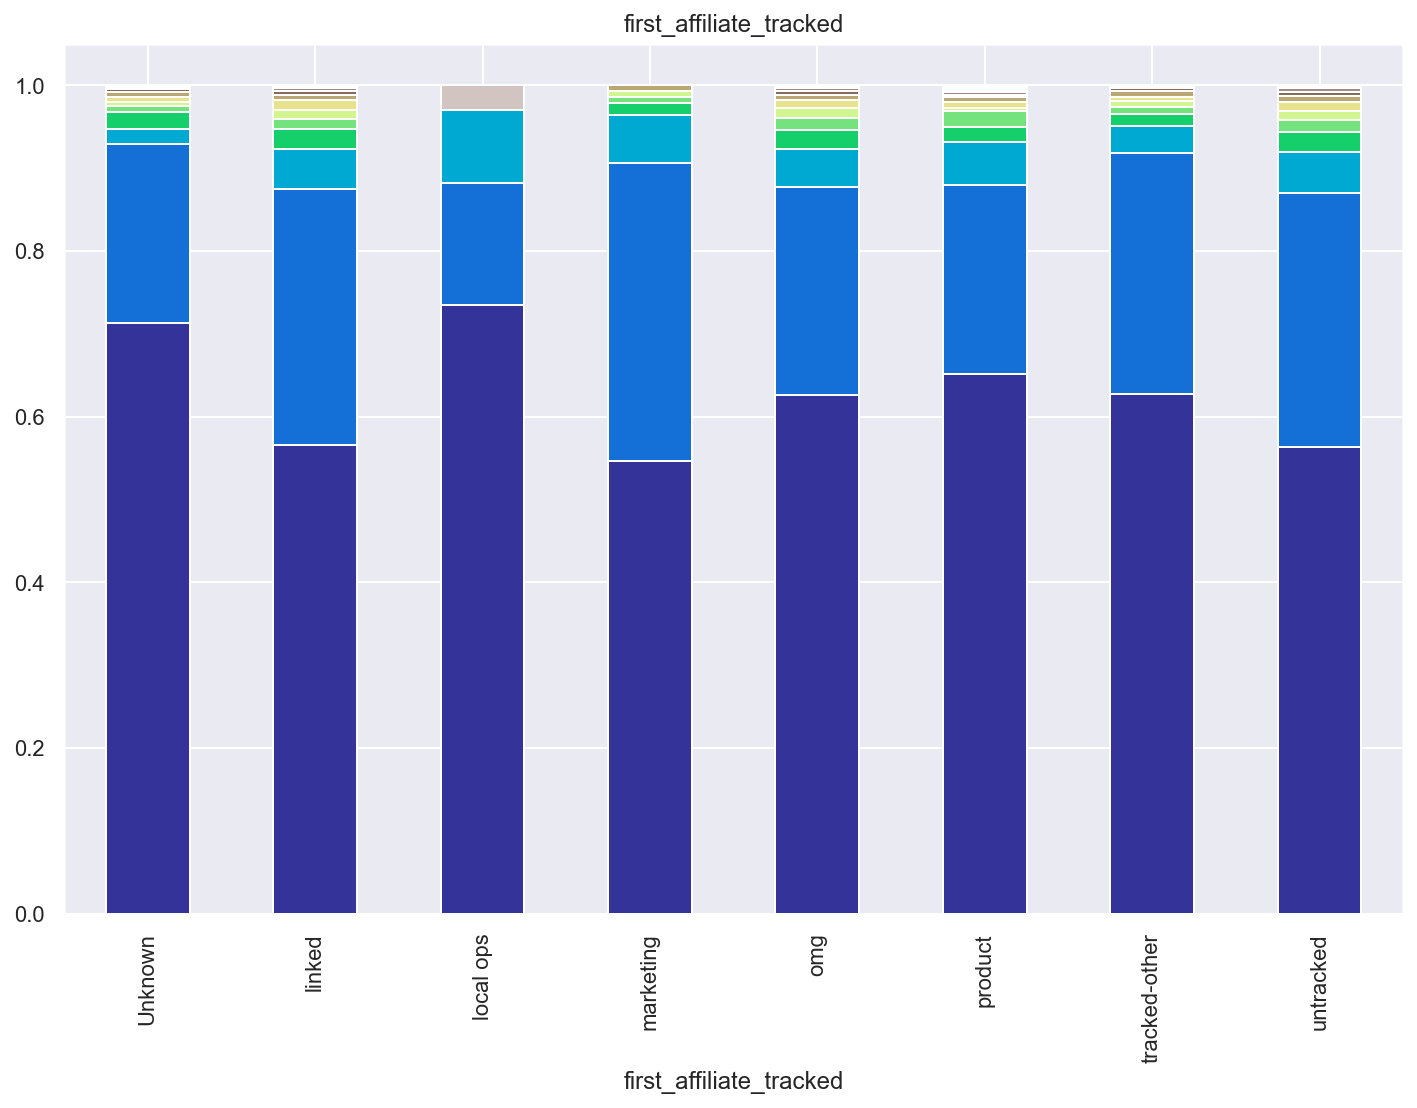

In [92]:
# 첫번째 제휴사 추적 : 가입하기 전에 사용자가 처음으로 상호 작용 한 마케팅 내용
stacked_bar('first_affiliate_tracked')

- 이번 그래프들을 통해 발견한 것들 
    - 1. **다이렉트 채널(에어비앤비)**은 예약으로 전환율가 가장 많은 반면, **콘텐츠 채널**의 예약 전환율이 가장 적다.
    - 2. **다이렉트 채널(에어비앤비)**와 **구글 채널**은 가장 인기 있는 제휴 업체이다.
    - 3. 예약 전환율은 **웨인(영국소셜미디어사이트)사이트**가 가장 낮은 반면 **다음(한국검색사이트)사이트**가 가장 높다. 하지만 **다음사이트**의 경우 이용수가 극히 적을 수 있어 이를 감안해야 한다.
    - 4. 이외에도 **구글과**과 **크레이그리스트(개인 광고, 직업, 주택 공급, 이력서, 토론 공간 등을 제공하는 안내 광고 웹사이트)**는 예약전환율이 높은 편이다.  
    - 5. 첫번째 제휴사가 **마케팅 제휴사**를 가지고 있는 사람들이 예약할 가능성이 가장 높았다. **로컬 제휴사**나 **제휴사가 없는** 사람들은 예약할 가능성이 가장 낮았다.

#### 6) 가입 흐름

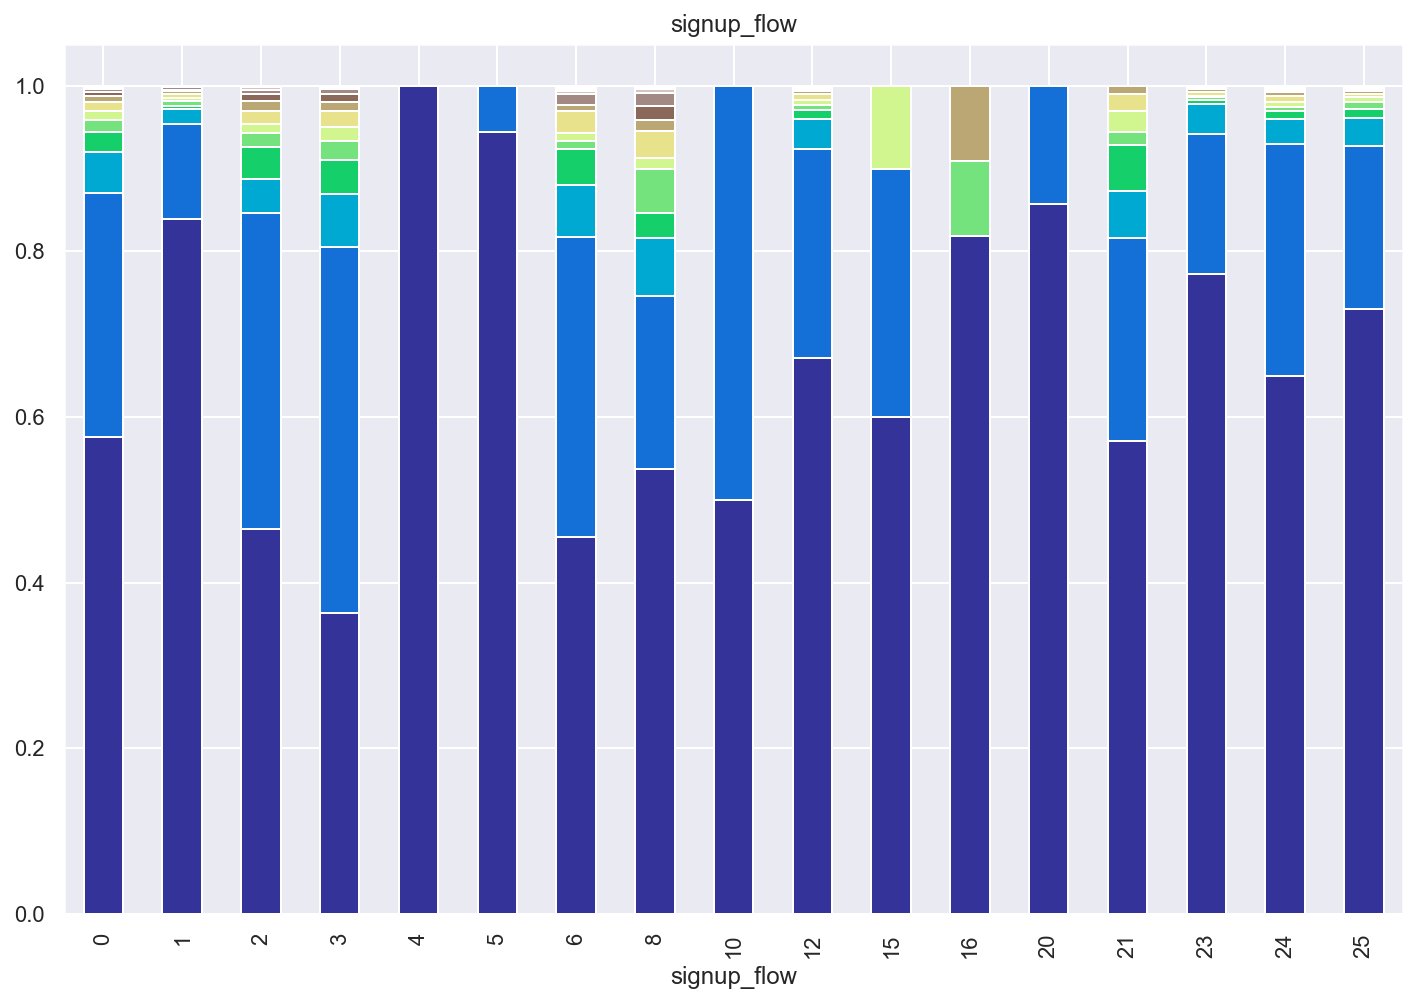

In [93]:
stacked_bar('signup_flow')

- 가입흐름 수치 3을 가진 사람들이 에어비앤비를 예약할 가능성이 가장 높다. 
- 반대로, 가입 흐름 4와 5를 가진 사람들은 가장 덜 예약할 가능성이 있다.

#### 7) 사용한 디바이스, 브라우저 및 앱 유형

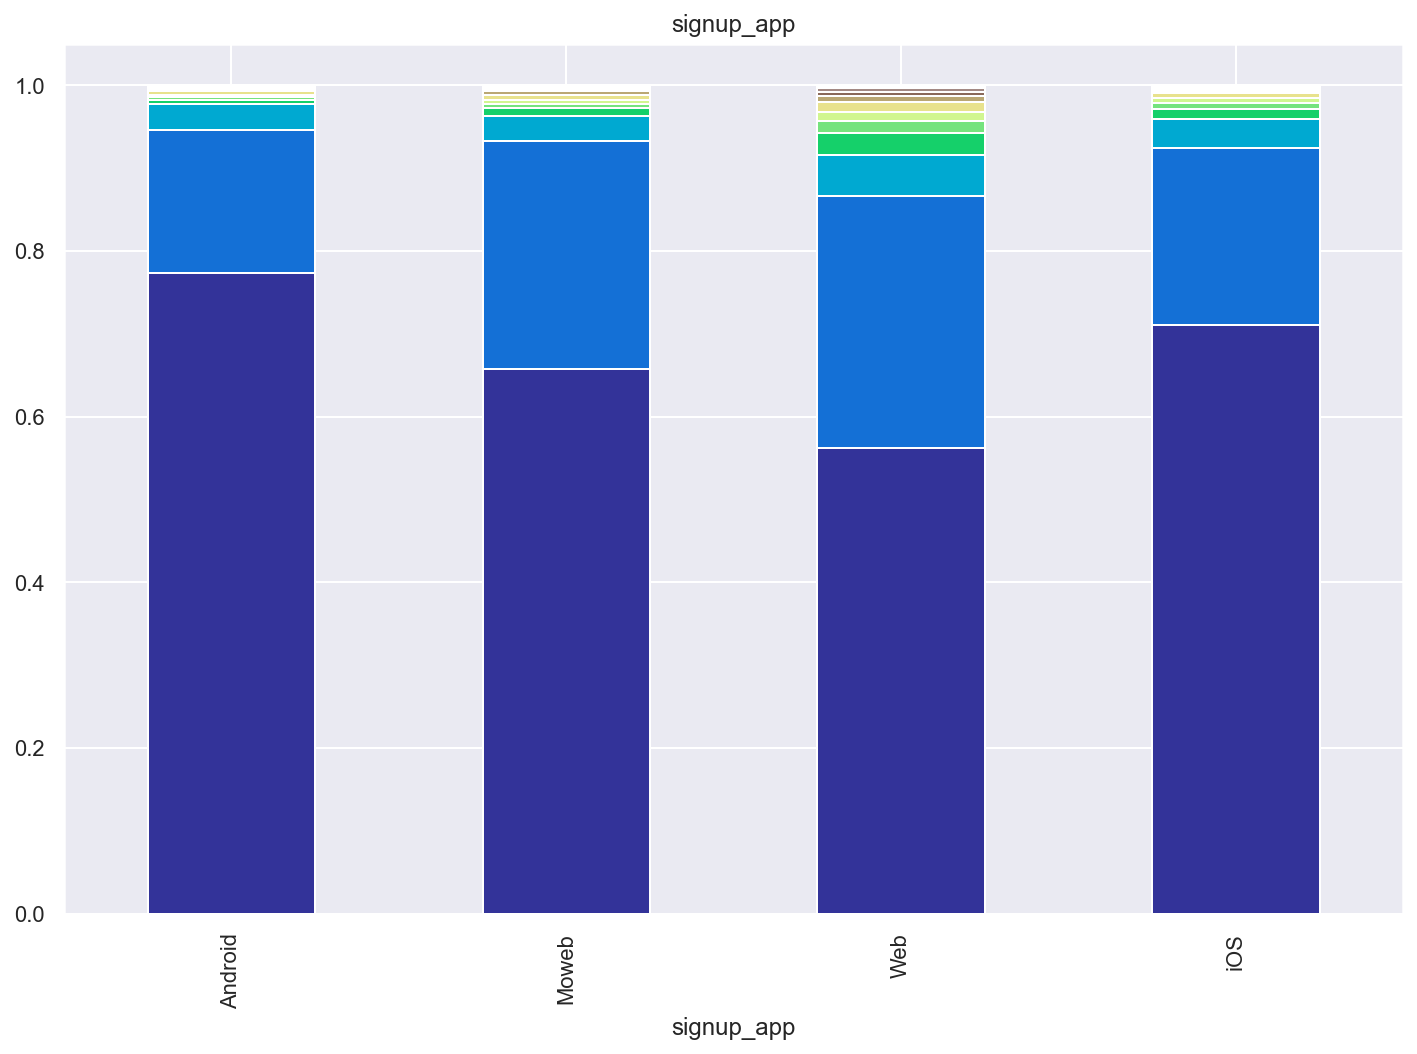

In [94]:
stacked_bar('signup_app')

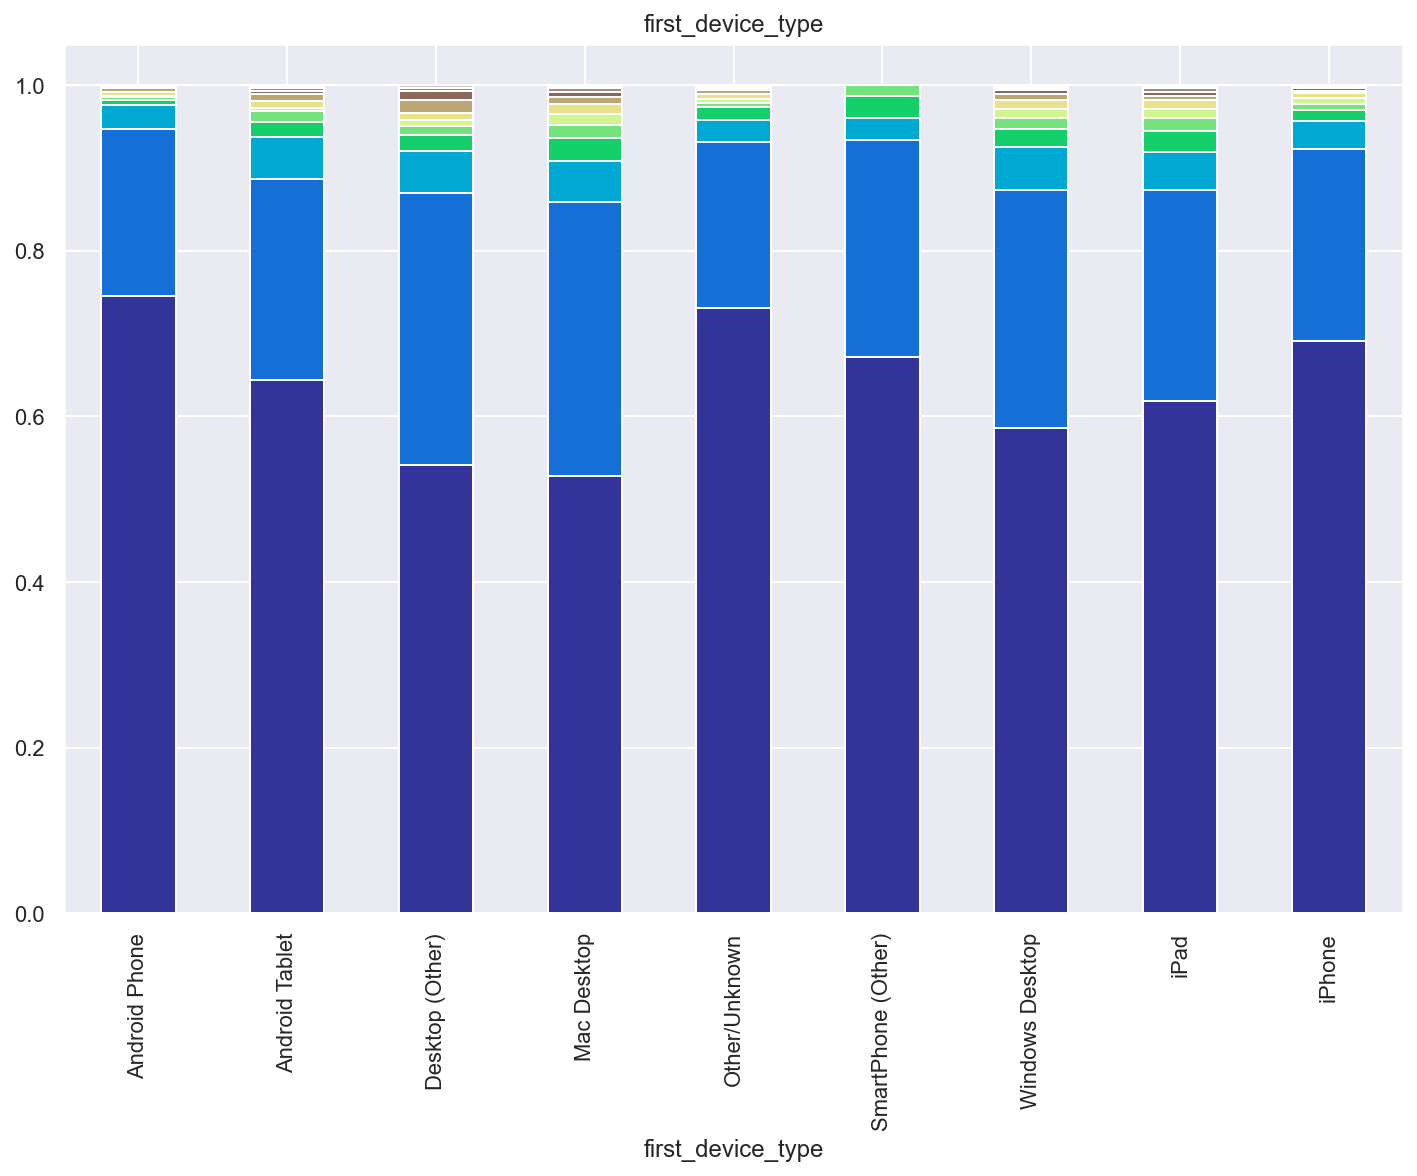

In [95]:
stacked_bar('first_device_type')

- 웹 사용자는 에어비앤비를 예약 할 가능성이 가장 높고, Android 사용자는 예약 할 가능성이 가장 낮음.
- 안드로이드 폰을 가지고 있거나 기기를 알 수 없는 사용자들은 에어비앤비 예약이 적고, 데스크톱 (Mac 또는 기타) 사용자들이 예약을 많이함.
- 세가지로 정리가능
    - 1. 데스크톱 사용자가 에어비앤비를 예약 할 가능성이 높다. 
    - 2. Apple 사용자는 에어비앤비 어플보다 웹 사이트에서 예약 비율이 높다.. 
    - 3. Android 사용자(안드로이드폰, 안드로이드 테블릿)의 예약율은 가장 적다.

#### 8) 에어비앤비 계정 생성 일자 

In [97]:
# 범주형 -> datetime 형식으로 변환 
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])

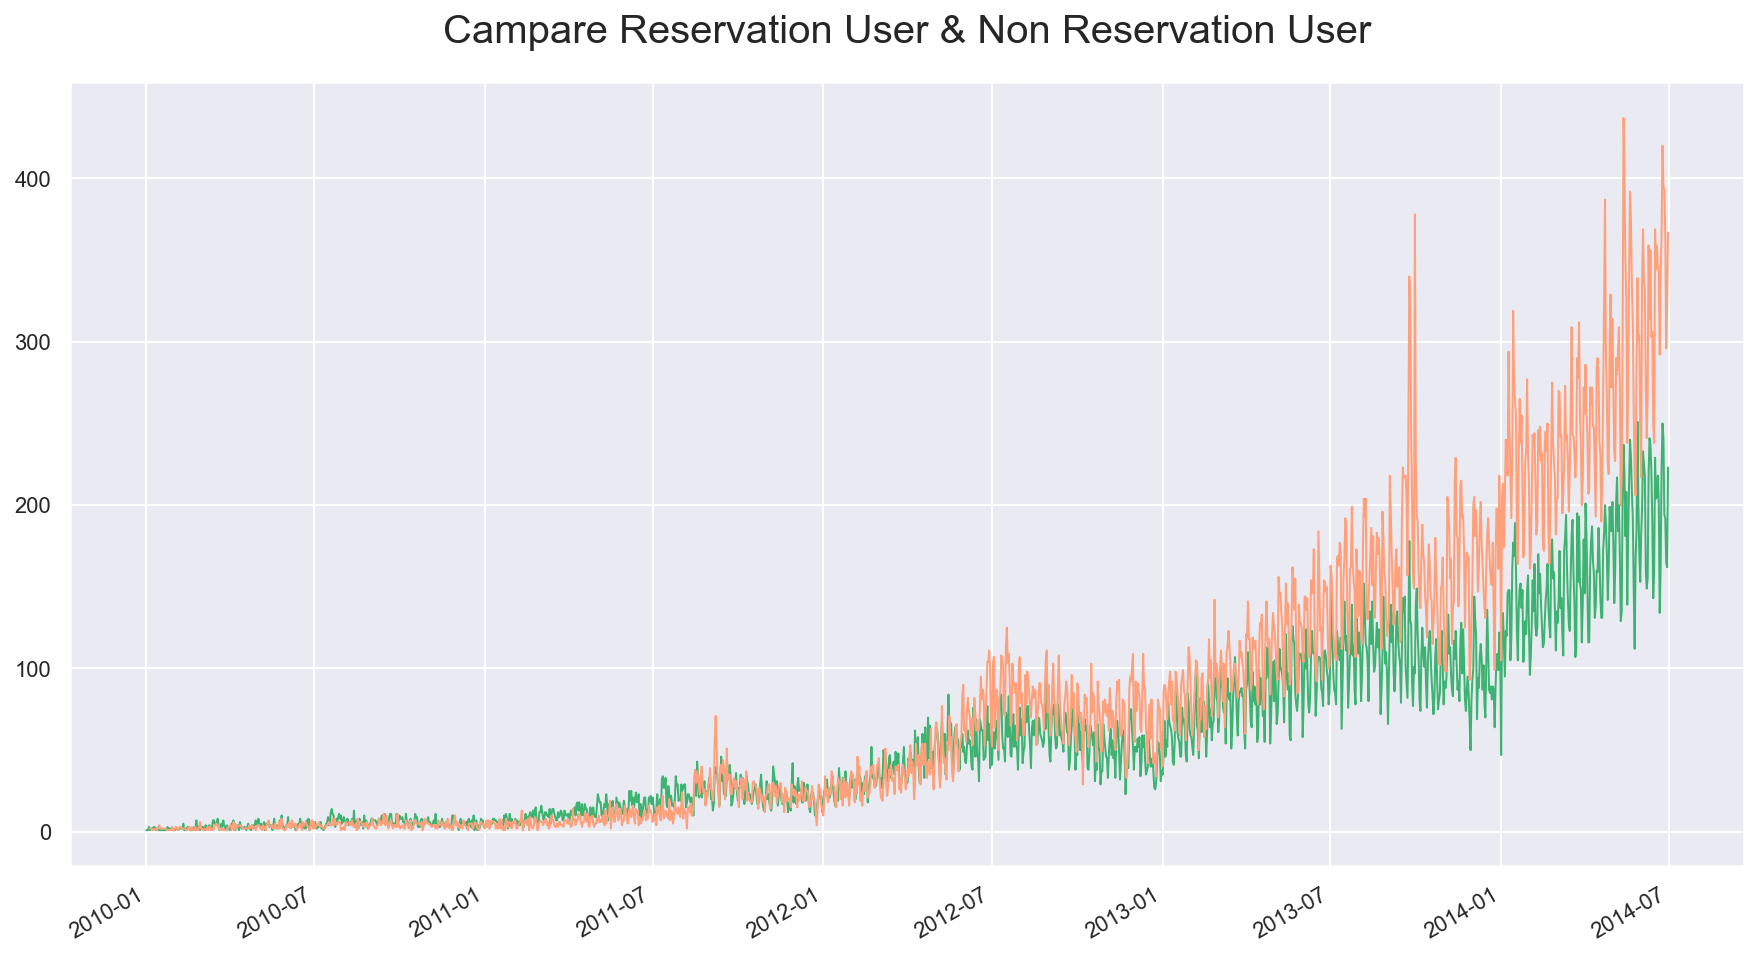

In [109]:
# 그래프로 나타내기 (예약을 하지 않은 그룹을 뺀 데이터와 빼지 않은 데이터의 계정 생성 일자 비교)
plt.figure(figsize=(15,8))
plt.title("Campare Reservation User & Non Reservation User", fontsize=20, pad=20)
# 예약을 한번도 하지 않는 그룹을 뺀 데이터 추출 (녹색)
df_train[df_train['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='#3CB371')
# 예약을 한번도 하지 않은 그룹을 포함한 데이터 추출 (빨강)
df_train[df_train['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='#FFA07A')

plt.show()

- 시간이 지남에 따라 **예약하지 않은 사용자의 수**가 **예약 사용자 수**보다 증가. 
- 이는 많은 사람들이 예약할 숙소를 보기 위해 숙소 검색용도로 사이트를 이용하고 있을 수도 있고, 사용자가 사이트 내에 오래 머물러 계속 검색하다가 나중에 숙소를 예약하는 경우가 있을 수 있다. 
- 이는 사용자가 에어비앤비에서 계정을 빨리 만들수록 에어비앤비를 통해 실제로 예약까지 할 수도 있지 않을까 라는 생각까지 할 수 있다.